In [1]:
!pip install albumentations

In [2]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm
import albumentations

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 32
SEED = 1488
IMAGE_SIZE = 380
NUM_CLASSES = 6
TRAIN_IMG_PATH = "/app/_data/cropped_all_v1/"
TEST_IMG_PATH = "/app/_data/test_images/"

In [4]:
# df_train = pd.read_csv('../_data/df_csv/labels_21_20.csv', index_col=[0])
feature_columns = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']
df_coordinates = pd.read_csv('../_data/df_csv/df_boxes_colab.csv', index_col=[0])

In [5]:
df_train = pd.read_csv('/app/_data/df_csv/labels_21_20_plus_wrong_upsample_plus_upsample.csv', index_col=[0])
test_20_only_one_label = pd.read_csv('../_data/df_csv/test_20_only_one_label.csv', index_col=[0])

# df_train = df_train.join(df_coordinates, on='image')
df_train = pd.concat([df_train, test_20_only_one_label], axis=0, ignore_index=True)

In [6]:
df_train

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,bf96a3e0bc4f8160.jpg,scab,0,0,0,0,0,1
1,c433bed1642d9de0.jpg,complex,1,0,0,0,0,0
2,91f6c89ade1cd60a.jpg,rust,0,0,0,0,1,0
3,2_fb4a41dc271603d7.jpg,scab frog_eye_leaf_spot,0,1,0,0,0,1
4,3_bdcc9e80392c4f36.jpg,scab frog_eye_leaf_spot complex,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...
34525,Test_66.jpg,scab,0,0,0,0,0,1
34526,Test_70.jpg,scab,0,0,0,0,0,1
34527,Test_72.jpg,scab,0,0,0,0,0,1
34528,Test_73.jpg,scab,0,0,0,0,0,1


In [7]:
# # for 380*380
# transform = albumentations.Compose(
#     [
#         albumentations.CLAHE(p=0.1, clip_limit=(1, 1), tile_grid_size=(8, 8)),
#         albumentations.OneOf(
#             [
#                 albumentations.MotionBlur((3, 3)),
#                 albumentations.MedianBlur(blur_limit=3),
#                 albumentations.GaussianBlur(
#                     blur_limit=(3, 3), sigma_limit=0),
#                 albumentations.Blur(blur_limit=(3, 3)),
#             ],
#             p=0.5,
#         ),
#         albumentations.OneOf(
#             [
#                 albumentations.GaussNoise(var_limit=[10, 50], mean=1),
#                 albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.01, 0.05)),
#                 albumentations.ImageCompression(
#                     quality_lower=70, quality_upper=100, compression_type=1
#                 ),
#                 albumentations.MultiplicativeNoise(
#                     multiplier=(0.95, 1.05), per_channel=True, elementwise=True
#                 ),
#                 albumentations.Downscale(
#                     scale_min=0.6, scale_max=0.99, interpolation=4
#                 ),
#             ],
#             p=0.5,
#         ),
#         albumentations.OneOf(
#             [
#                 albumentations.HueSaturationValue(
#                     hue_shift_limit=(-7, 7),
#                     sat_shift_limit=(-10, 10),
#                     val_shift_limit=(-10, 10),
#                 ),
#                 albumentations.RandomBrightnessContrast(
#                     brightness_limit=0.15,
#                     contrast_limit=0.2,
#                     brightness_by_max=True,
#                     always_apply=False,
#                 ),
#             ],
#             p=0.5,
#         ),
#         albumentations.OneOf(
#             [
#                 albumentations.OpticalDistortion(
#                     distort_limit=0.5,
#                     shift_limit=0.5,
#                     border_mode=1,
#                 ),
#                 albumentations.ElasticTransform(
#                     alpha=2.0,
#                     sigma=50.0,
#                     alpha_affine=30.0,
#                     interpolation=0,
#                     border_mode=1,
#                 ),
#                 albumentations.GridDistortion(
#                     num_steps=5, distort_limit=0.3, interpolation=0, border_mode=1
#                 ),
#             ],
#             p=0.5,
#         ),
#         albumentations.OneOf(
#             [
#                 albumentations.Rotate(
#                     limit=(-180, 180), interpolation=0, border_mode=1
#                 ),
#                 albumentations.ShiftScaleRotate(
#                     shift_limit=0.05,
#                     scale_limit=0.05,
#                     rotate_limit=180,
#                     interpolation=0,
#                     border_mode=1,
#                 ),
#                 albumentations.HorizontalFlip(),
#                 albumentations.VerticalFlip(),
#             ],
#             p=0.5,
#         ),
#     ]
# )

In [8]:
# for 380*380
transform = albumentations.Compose(
    [
        albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
        albumentations.OneOf(
            [
                albumentations.MotionBlur((3, 3)),
                albumentations.MedianBlur(blur_limit=3),
                albumentations.GaussianBlur(
                    blur_limit=(3, 3), sigma_limit=0),
                albumentations.Blur(blur_limit=(3, 3)),
            ],
            p=0.2,
        ),
        albumentations.OneOf(
            [
                albumentations.GaussNoise(var_limit=[10, 50], mean=1),
                albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.01, 0.05)),
                albumentations.ImageCompression(
                    quality_lower=70, quality_upper=100, compression_type=1
                ),
                albumentations.MultiplicativeNoise(
                    multiplier=(0.95, 1.05), per_channel=True, elementwise=True
                ),
                albumentations.Downscale(
                    scale_min=0.6, scale_max=0.99, interpolation=4
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=(-7, 7),
                    sat_shift_limit=(-10, 10),
                    val_shift_limit=(-10, 10),
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.15,
                    contrast_limit=0.2,
                    brightness_by_max=True,
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.OpticalDistortion(
                    distort_limit=0.05,
                    shift_limit=0.05,
                    border_mode=2,
                ),
                albumentations.ElasticTransform(
                    alpha=2.0,
                    sigma=50.0,
                    alpha_affine=10.0,
                    interpolation=0,
                    border_mode=2,
                ),
                albumentations.GridDistortion(
                    num_steps=5, distort_limit=0.3, interpolation=0, border_mode=2
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Rotate(
                    limit=(-180, 180), interpolation=0, border_mode=2
                ),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=180,
                    interpolation=0,
                    border_mode=2,
                ),
            ],
            p=0.5,
        ),
    ]
)

In [35]:
# class Generator(keras.utils.Sequence):
#     def __init__(
#         self,
#         df,
#         images_src_dir,
#         batch_size,
#         target_image_size,
#         shuffle=False,
#         augment = True,
#         crop = False,
#         resize=False
#     ):
#         self.shuffle = shuffle
#         self.batch_size = BATCH_SIZE
#         self.df = df
#         self.images_dir = images_src_dir
#         self.target_image_size = (IMAGE_SIZE, IMAGE_SIZE)
#         self.augment = augment
#         self.crop = crop
#         self.resize = resize
#         # create label index map
#         self.labels = self._read_labels()
#         self.ids = list(self.labels.keys())  # list of ids


#         # shuffle data, also repeated after each epoch if needed
#         if self.shuffle:
#             np.random.shuffle(self.ids)

       
#         self.n_samples = self.df.shape[0]
#         self.n_batches = self.n_samples // self.batch_size


#     def _read_labels(self):
#         """
#         Convert labels to one-hot representation
#         Returns dict mapping to 1-hot label
#         """

#         df_labels = self.df

#         # label indexes in 1-hot representation
#         label_ixs = self.df[feature_columns].values
#         self.label_ixs = label_ixs

#         labels = {}  # id: 1h

#         for i in df_labels.loc[:,'image'].tolist():
#             ids = df_labels.loc[df_labels.loc[:,'image'] == i].index[0]
#             labels[i] = list(df_labels.loc[ids, feature_columns].values)
#         return labels

#     def __len__(self):
#         """
#         Length in batches
#         """
#         return self.n_batches

#     def __getitem__(self, b_ix):
#         """
#         Produce batch, by batch index
#         """

#         assert b_ix < self.n_batches

#         b_X = np.zeros(
#             (self.batch_size, self.target_image_size[0], self.target_image_size[1], 3),
#             dtype=np.uint8,
#         )

#         b_Y = np.zeros(
#             (self.batch_size, self.label_ixs.shape[1]),
#             dtype=np.uint8,
#         )

#         for i in range(self.batch_size):
#             b_X[i], b_Y[i] = self.get_one(
#                 i + self.batch_size * b_ix,
#             )

#         return (b_X, b_Y)

#     def get_one(
#         self, one_ix
#     ):
#         """
#         Get single item by absolute index
#         """
#         augment = self.augment
#         crop = self.crop
#         id = self.ids[one_ix]
#         src_file = self.images_dir+id

#         # read file
#         x = tf.io.read_file(src_file)
#         x = tf.image.decode_jpeg(x, channels=3)
# #         x = tf.cast(x, tf.uint8)
#         if crop:
#             df_c = self.df
#             coord = df_c[df_c["image"] == id][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
# #                 orig_hight = x.shape[0]
# #                 orig_width = x.shape[1]
# #                 x_min = coord[0]
# #                 y_min = coord[1]
# #                 x_max = coord[2]
# #                 y_max = coord[3]
# #                 x = x[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]

#             orig_hight = x.shape[0]
#             orig_width = x.shape[1]
#             x_min = coord[0]
#             y_min = coord[1]
#             x_max = coord[2]
#             y_max = coord[3]
#             final_hight = (y_max - y_min) * orig_hight
#             final_width = (x_max - x_min) * orig_width
#             x = tf.image.crop_to_bounding_box(
#                 x.numpy(),
#                 offset_height=np.int(y_min * orig_hight),
#                 offset_width=np.int(x_min * orig_width),
#                 target_height=np.int(final_hight),
#                 target_width=np.int(final_width),
#             )
#         if self.resize:
#             x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
#         x = tf.cast(x, dtype='uint8')
#         x = np.array(x)
#         y = self.labels[id]

#         # augment
#         if augment:
#             x = self._augment_image(x)

#         # normalize (sample-wise)
#         if normalize:
#             x = x.astype(np.float32)
#             x = x - np.mean(x, axis=(0, 1))
#             x = x / np.std(x, axis=(0, 1))
        
         
#         return x.astype(np.uint8), y

#     def _augment_image(self, x):
#         """
#         Randomply augment image
#         """

#         x = transform(image=np.array(x))['image']
#         return x

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.ids)

In [98]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        images_src_dir,
        batch_size,
        target_image_size,
        shuffle=False,
        augment = True,
        crop = False,
        resize=False,
        normalize=False
    ):
        self.shuffle = shuffle
        self.batch_size = BATCH_SIZE
        self.df = df
        self.images_dir = images_src_dir
        self.target_image_size = (IMAGE_SIZE, IMAGE_SIZE)
        self.augment = augment
        self.crop = crop
        self.resize = resize
        # create label index map
        self.labels = self._read_labels()
        self.ids = self.label_ixs  # list of ids
        self.image_ixs = image_ixs
        self.normalize = normalize
        # shuffle data, also repeated after each epoch if needed
        if self.shuffle:
            np.random.shuffle(self.ids)

       
        self.n_samples = self.df.shape[0]
        self.n_batches = self.n_samples // self.batch_size


    def _read_labels(self):
        """
        Convert labels to one-hot representation
        Returns dict mapping to 1-hot label
        """

        df_labels = self.df

        # label indexes in 1-hot representation
        label_ixs = self.df[feature_columns].values
        self.label_ixs = label_ixs
        image_ixs = df_labels['image'].values
        self.image_ixs = image_ixs
        labels = []  # id: 1h

        for i in range(len(image_ixs)):
            labels.append([image_ixs[i], label_ixs[i]])
        return labels
    
    def __len__(self):
        """
        Length in batches
        """
        return self.n_batches

    def __getitem__(self, b_ix):
        """
        Produce batch, by batch index
        """

        assert b_ix < self.n_batches

        b_X = np.zeros(
            (self.batch_size, self.target_image_size[0], self.target_image_size[1], 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.label_ixs.shape[1]),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i], b_Y[i] = self.get_one(
                i + self.batch_size * b_ix,
            )

        return (b_X, b_Y)

    def get_one(
        self, one_ix
    ):
        """
        Get single item by absolute index
        """
        augment = self.augment
        crop = self.crop
        normalize = self.normalize
        id = self.labels[one_ix][0]
        src_file = self.images_dir+id

        # read file
        x = tf.io.read_file(src_file)
        x = tf.image.decode_jpeg(x, channels=3)
        x = tf.cast(x, tf.uint8)
        if crop:
            df_c = self.df
            coord = df_c[df_c["image"] == id][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
#                 orig_hight = x.shape[0]
#                 orig_width = x.shape[1]
#                 x_min = coord[0]
#                 y_min = coord[1]
#                 x_max = coord[2]
#                 y_max = coord[3]
#                 x = x[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]

            orig_hight = x.shape[0]
            orig_width = x.shape[1]
            x_min = coord[0]
            y_min = coord[1]
            x_max = coord[2]
            y_max = coord[3]
            final_hight = (y_max - y_min) * orig_hight
            final_width = (x_max - x_min) * orig_width
            x = tf.image.crop_to_bounding_box(
                x.numpy(),
                offset_height=np.int(y_min * orig_hight),
                offset_width=np.int(x_min * orig_width),
                target_height=np.int(final_hight),
                target_width=np.int(final_width),
            )
        if self.resize:
            x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
        x = tf.cast(x, dtype='uint8')
        x = np.array(x)
        y = self.labels[one_ix][1]

        # augment
        if augment:
            x = self._augment_image(x)

        # normalize (sample-wise)
        if normalize:
            x = x.astype(np.float32)
            x = x - np.mean(x, axis=(0, 1))
            x = x / np.std(x, axis=(0, 1))
        
         
        return x.astype(np.uint8), y

    def _augment_image(self, x):
        """
        Randomply augment image
        """

        x = transform(image=np.array(x))['image']
        return x

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.ids)

In [99]:
gen = Generator(
    df=df_train.head(1).sample(100, replace=True),
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False
)

In [107]:
gen.image_ixs

array(['bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf96a3e0bc4f8160.jpg', 'bf96a3e0bc4f8160.jpg',
       'bf

In [102]:
len(gen.__getitem__(2))

2

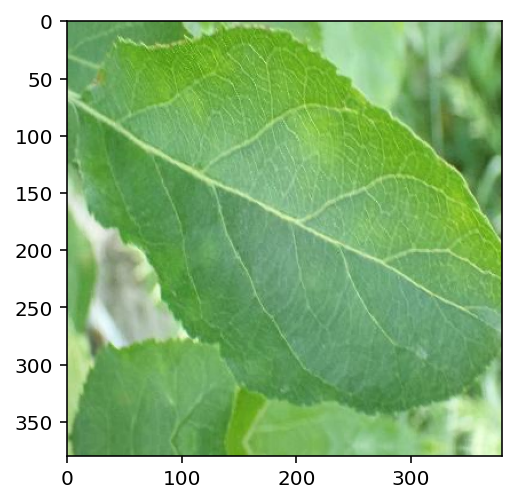

In [103]:
# img = Image.open(gen_train.get_one(1)[0])
plt.imshow(gen.get_one(1)[0])

In [74]:
def pred_to_labels(pred, thresh=0.5, labels=feature_columns):
    pred = [labels[i] for i in range(len(labels)) if pred[i] > thresh]
    pred = " ".join(pred)
    return pred

In [40]:
def parse_test_image(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(
        img,
        (IMAGE_SIZE, IMAGE_SIZE),
    )
    img = tf.cast(img, tf.uint8)
    return img
def predict_new(path, model):
    img = parse_test_image(path)
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

# Datasets

In [41]:
# df_train = pd.read_csv('../_data/df_csv/labels_21_20.csv', index_col=[0])
# feature_columns = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']
# df_coordinates = pd.read_csv('../_data/df_csv/df_boxes_colab.csv', index_col=[0])
# df_train = df_train.join(df_coordinates, on='image')

In [42]:
df_train.query('image == "da8770e819d2696d.jpg"')

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab


In [43]:
df_train = df_train.query('image != "da8770e819d2696d.jpg"').reset_index(drop=True)

In [44]:
df_train

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,bf96a3e0bc4f8160.jpg,scab,0,0,0,0,0,1
1,c433bed1642d9de0.jpg,complex,1,0,0,0,0,0
2,91f6c89ade1cd60a.jpg,rust,0,0,0,0,1,0
3,2_fb4a41dc271603d7.jpg,scab frog_eye_leaf_spot,0,1,0,0,0,1
4,3_bdcc9e80392c4f36.jpg,scab frog_eye_leaf_spot complex,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...
34524,Test_66.jpg,scab,0,0,0,0,0,1
34525,Test_70.jpg,scab,0,0,0,0,0,1
34526,Test_72.jpg,scab,0,0,0,0,0,1
34527,Test_73.jpg,scab,0,0,0,0,0,1


In [46]:
# for i  in df_train['image'].tolist():
#     if i not in os.listdir(TRAIN_IMG_PATH):
#         print(i)


# StratifiedShuffleSplit

In [47]:
df = df_train.copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)

for train_index, valid_index in sss.split(df["image"], df["labels"]):
    train, valid = df.loc[train_index], df.loc[valid_index]

In [48]:
gen_train = Generator(
    df=train,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=True, augment=True, crop=False, resize=False
)

In [49]:
gen_valid = Generator(
    df=valid,
    images_src_dir=TRAIN_IMG_PATH,
    target_image_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=False, augment=False, crop=False, resize=False
)

In [50]:
len(gen_valid.ids)

3323

In [51]:
x0, y0 = gen_train.get_one(55)

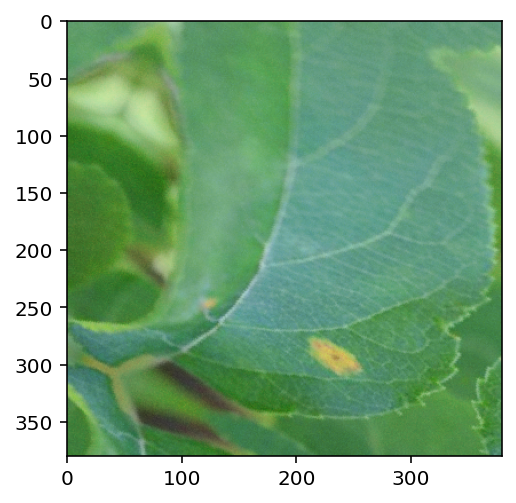

In [52]:
plt.imshow(x0)

In [53]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

In [54]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/albumentations/eff4_ns_cropped_alb_big_1.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.5,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
]

In [55]:
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)

In [56]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
base_model.load_weights(
    "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
    by_name=True,
    skip_mismatch=True,
)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [57]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=[
        "acc",
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
    ],
)

In [58]:
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=(train.shape[0] * 0.9) // BATCH_SIZE,
    validation_steps=(valid.shape[0] * 0.1) // BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/100
  2/874 [..............................] - ETA: 5:53 - loss: 0.6902 - acc: 0.1875 - recall_1: 0.4000 - precision_1: 0.1724 - f1_score: 0.2141

UnknownError: 2 root error(s) found.
  (0) Unknown:  IndexError: list index out of range
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 679, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-35-da435f3707ec>", line 78, in __getitem__
    b_X[i], b_Y[i] = self.get_one(
  File "<ipython-input-35-da435f3707ec>", line 92, in get_one
    id = self.ids[one_ix]
IndexError: list index out of range
"""


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 828, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 900, in get
    six.reraise(*sys.exc_info())

  File "/usr/local/lib/python3.8/dist-packages/six.py", line 703, in reraise
    raise value

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 891, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 771, in get
    raise self._value

IndexError: list index out of range


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  IndexError: list index out of range
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 679, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-35-da435f3707ec>", line 78, in __getitem__
    b_X[i], b_Y[i] = self.get_one(
  File "<ipython-input-35-da435f3707ec>", line 92, in get_one
    id = self.ids[one_ix]
IndexError: list index out of range
"""


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 828, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 900, in get
    six.reraise(*sys.exc_info())

  File "/usr/local/lib/python3.8/dist-packages/six.py", line 703, in reraise
    raise value

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 891, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 771, in get
    raise self._value

IndexError: list index out of range


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[assert_greater_equal_1/Assert/AssertGuard/else/_1723/assert_greater_equal_1/Assert/AssertGuard/Assert/data_0/_270]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_112168]

Function call stack:
train_function -> train_function


In [31]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

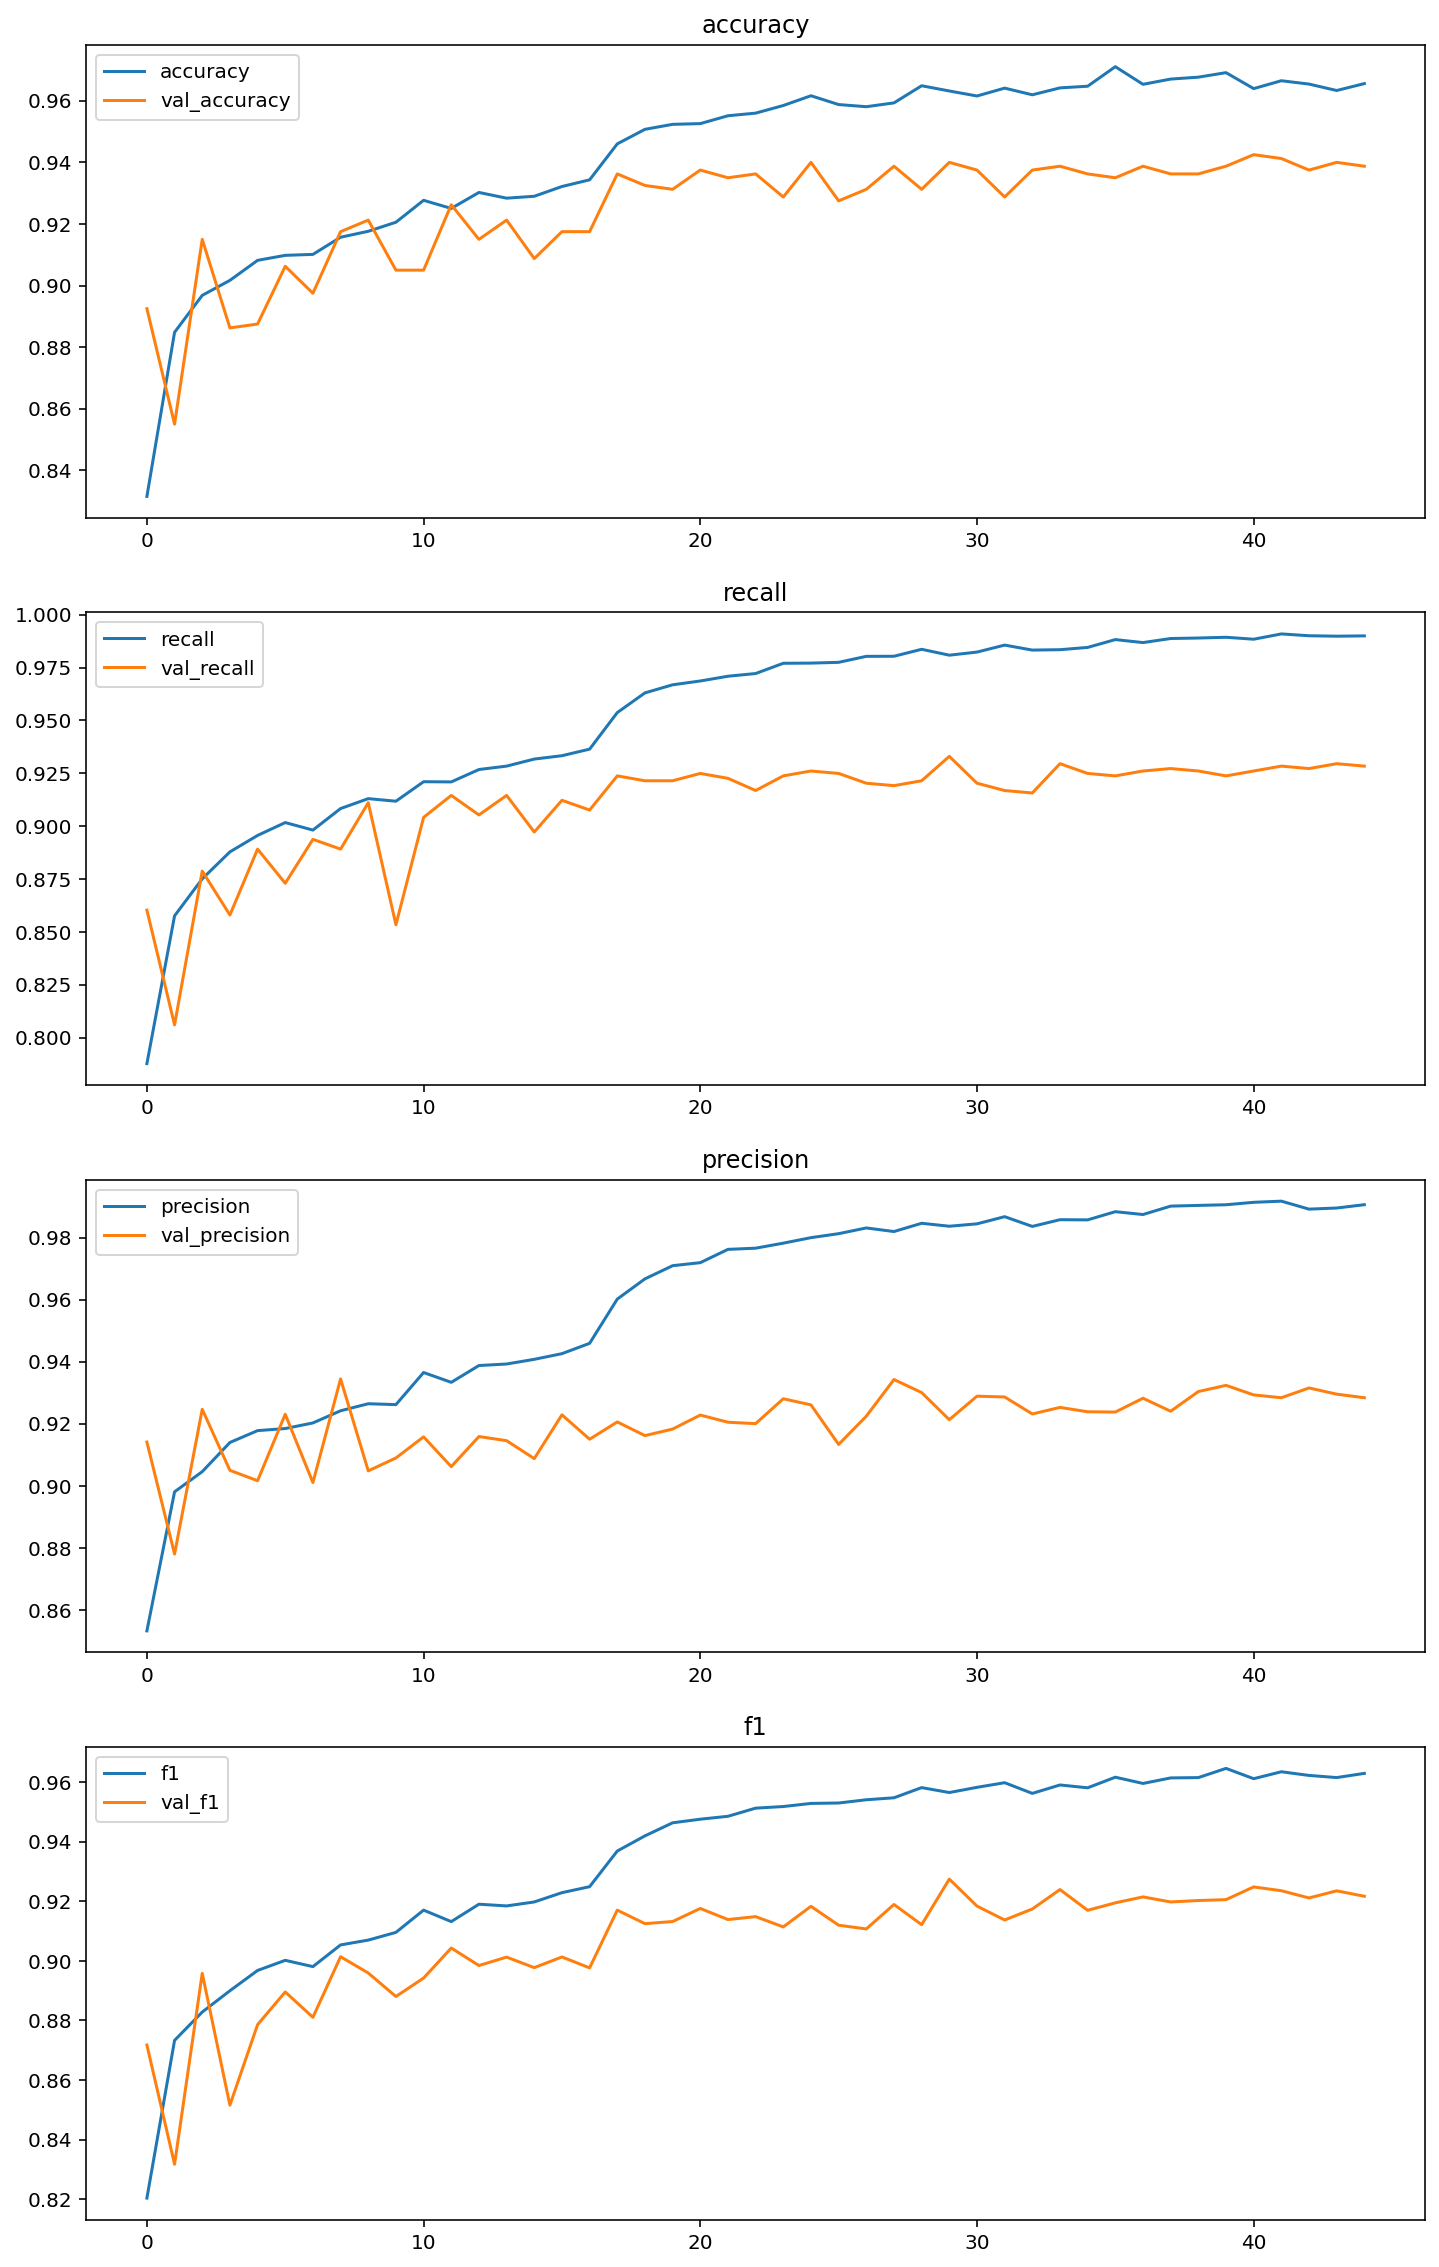

In [33]:
plot_curves(history, loss=False)

In [29]:
# model = keras.models.load_model("/app/_data/models/new/bond_box_999_200.h5")

In [25]:
def parse_all(file_path):
    img = tf.io.read_file(TRAIN_IMG_PATH+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def predict_new(path, model):
    img = parse_all(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])
# def parse_all(file_path):
#     img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(
#         img,
#         (380, 380),
#     )
#     img = tf.image.convert_image_dtype(img, tf.uint8)
#     return img


# def predict_new(path, model):
#     img = parse_all(path)
#     img = tf.expand_dims(img, axis=0)
#     pred = model.predict(img)
#     return pred[0]

In [26]:
# a = predict_new('9eb93fe282326266.jpg', model)

In [27]:
df_sub = pd.DataFrame(columns=['image','labels'])
for img_name in os.listdir(TRAIN_IMG_PATH):
    pred = predict_new(img_name, model)

    df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )

print(df_sub.head())
# df_boxes = pd.DataFrame()
# for img_name in os.listdir(PATH + "images/"):
#     if img_name[-4:] == ".jpg":
#         pred = predict_new(img_name, model)
#         df_boxes.loc[img_name, "x_min"] = pred[0]
#         df_boxes.loc[img_name, "y_min"] = pred[1]
#         df_boxes.loc[img_name, "x_max"] = pred[2]
#         df_boxes.loc[imga_name, "y_max"] = pred[3]

                  image                   labels
0  bfc6d90f402f4c34.jpg  frog_eye_leaf_spot scab
1  9eb93fe282326266.jpg           powdery_mildew
2  f4cb3a8f41b413e4.jpg       frog_eye_leaf_spot
3  98322eab16bef2c1.jpg                     rust
4  dad5d6250cae80b7.jpg                  complex


In [34]:
# df_boxes.to_csv(PATH + "df_boxes_20.csv")

In [28]:
df_sub = df_sub.merge(
    df_train[["image", "labels"]],
    on="image",
    how="left",
    suffixes=("_pred", "_true"),
)

In [29]:
df_sub.to_csv("/app/sandbox/wrong_predictions/eff4/eff4_ns_cr_alb_1.csv")

In [ ]:
# df_boxes

In [30]:
df_sub[df_sub["labels_pred"] == ""]["labels_true"].value_counts()

healthy                    5
complex                    4
rust                       4
scab                       3
scab frog_eye_leaf_spot    2
powdery_mildew             2
Name: labels_true, dtype: int64

In [46]:
PATH+'images/'+

'/app/_data/images/'

In [37]:
import shutil

In [47]:
for img in labels_2020["image"].values.tolist():
    shutil.move(PATH + "images/" + img, PATH + "train_images/" + img)

'/app/_data/train_images/Train_0.jpg'

'/app/_data/train_images/Train_1.jpg'

'/app/_data/train_images/Train_2.jpg'

'/app/_data/train_images/Train_3.jpg'

'/app/_data/train_images/Train_4.jpg'

'/app/_data/train_images/Train_5.jpg'

'/app/_data/train_images/Train_6.jpg'

'/app/_data/train_images/Train_7.jpg'

'/app/_data/train_images/Train_8.jpg'

'/app/_data/train_images/Train_9.jpg'

'/app/_data/train_images/Train_10.jpg'

'/app/_data/train_images/Train_11.jpg'

'/app/_data/train_images/Train_12.jpg'

'/app/_data/train_images/Train_13.jpg'

'/app/_data/train_images/Train_14.jpg'

'/app/_data/train_images/Train_15.jpg'

'/app/_data/train_images/Train_16.jpg'

'/app/_data/train_images/Train_17.jpg'

'/app/_data/train_images/Train_18.jpg'

'/app/_data/train_images/Train_19.jpg'

'/app/_data/train_images/Train_20.jpg'

'/app/_data/train_images/Train_21.jpg'

'/app/_data/train_images/Train_22.jpg'

'/app/_data/train_images/Train_23.jpg'

'/app/_data/train_images/Train_24.jpg'

'/app/_data/train_images/Train_25.jpg'

'/app/_data/train_images/Train_26.jpg'

'/app/_data/train_images/Train_27.jpg'

'/app/_data/train_images/Train_28.jpg'

'/app/_data/train_images/Train_29.jpg'

'/app/_data/train_images/Train_30.jpg'

'/app/_data/train_images/Train_31.jpg'

'/app/_data/train_images/Train_32.jpg'

'/app/_data/train_images/Train_33.jpg'

'/app/_data/train_images/Train_34.jpg'

'/app/_data/train_images/Train_35.jpg'

'/app/_data/train_images/Train_36.jpg'

'/app/_data/train_images/Train_37.jpg'

'/app/_data/train_images/Train_38.jpg'

'/app/_data/train_images/Train_39.jpg'

'/app/_data/train_images/Train_40.jpg'

'/app/_data/train_images/Train_41.jpg'

'/app/_data/train_images/Train_42.jpg'

'/app/_data/train_images/Train_43.jpg'

'/app/_data/train_images/Train_44.jpg'

'/app/_data/train_images/Train_45.jpg'

'/app/_data/train_images/Train_46.jpg'

'/app/_data/train_images/Train_47.jpg'

'/app/_data/train_images/Train_48.jpg'

'/app/_data/train_images/Train_49.jpg'

'/app/_data/train_images/Train_50.jpg'

'/app/_data/train_images/Train_51.jpg'

'/app/_data/train_images/Train_52.jpg'

'/app/_data/train_images/Train_53.jpg'

'/app/_data/train_images/Train_54.jpg'

'/app/_data/train_images/Train_55.jpg'

'/app/_data/train_images/Train_56.jpg'

'/app/_data/train_images/Train_57.jpg'

'/app/_data/train_images/Train_58.jpg'

'/app/_data/train_images/Train_59.jpg'

'/app/_data/train_images/Train_60.jpg'

'/app/_data/train_images/Train_61.jpg'

'/app/_data/train_images/Train_62.jpg'

'/app/_data/train_images/Train_63.jpg'

'/app/_data/train_images/Train_64.jpg'

'/app/_data/train_images/Train_65.jpg'

'/app/_data/train_images/Train_66.jpg'

'/app/_data/train_images/Train_67.jpg'

'/app/_data/train_images/Train_68.jpg'

'/app/_data/train_images/Train_69.jpg'

'/app/_data/train_images/Train_70.jpg'

'/app/_data/train_images/Train_71.jpg'

'/app/_data/train_images/Train_72.jpg'

'/app/_data/train_images/Train_73.jpg'

'/app/_data/train_images/Train_74.jpg'

'/app/_data/train_images/Train_75.jpg'

'/app/_data/train_images/Train_76.jpg'

'/app/_data/train_images/Train_77.jpg'

'/app/_data/train_images/Train_78.jpg'

'/app/_data/train_images/Train_79.jpg'

'/app/_data/train_images/Train_80.jpg'

'/app/_data/train_images/Train_81.jpg'

'/app/_data/train_images/Train_82.jpg'

'/app/_data/train_images/Train_83.jpg'

'/app/_data/train_images/Train_84.jpg'

'/app/_data/train_images/Train_85.jpg'

'/app/_data/train_images/Train_86.jpg'

'/app/_data/train_images/Train_87.jpg'

'/app/_data/train_images/Train_88.jpg'

'/app/_data/train_images/Train_89.jpg'

'/app/_data/train_images/Train_90.jpg'

'/app/_data/train_images/Train_91.jpg'

'/app/_data/train_images/Train_92.jpg'

'/app/_data/train_images/Train_93.jpg'

'/app/_data/train_images/Train_94.jpg'

'/app/_data/train_images/Train_95.jpg'

'/app/_data/train_images/Train_96.jpg'

'/app/_data/train_images/Train_97.jpg'

'/app/_data/train_images/Train_98.jpg'

'/app/_data/train_images/Train_99.jpg'

'/app/_data/train_images/Train_100.jpg'

'/app/_data/train_images/Train_101.jpg'

'/app/_data/train_images/Train_102.jpg'

'/app/_data/train_images/Train_103.jpg'

'/app/_data/train_images/Train_104.jpg'

'/app/_data/train_images/Train_105.jpg'

'/app/_data/train_images/Train_106.jpg'

'/app/_data/train_images/Train_107.jpg'

'/app/_data/train_images/Train_108.jpg'

'/app/_data/train_images/Train_109.jpg'

'/app/_data/train_images/Train_110.jpg'

'/app/_data/train_images/Train_111.jpg'

'/app/_data/train_images/Train_112.jpg'

'/app/_data/train_images/Train_113.jpg'

'/app/_data/train_images/Train_114.jpg'

'/app/_data/train_images/Train_115.jpg'

'/app/_data/train_images/Train_116.jpg'

'/app/_data/train_images/Train_117.jpg'

'/app/_data/train_images/Train_118.jpg'

'/app/_data/train_images/Train_119.jpg'

'/app/_data/train_images/Train_120.jpg'

'/app/_data/train_images/Train_121.jpg'

'/app/_data/train_images/Train_122.jpg'

'/app/_data/train_images/Train_123.jpg'

'/app/_data/train_images/Train_124.jpg'

'/app/_data/train_images/Train_125.jpg'

'/app/_data/train_images/Train_126.jpg'

'/app/_data/train_images/Train_127.jpg'

'/app/_data/train_images/Train_128.jpg'

'/app/_data/train_images/Train_129.jpg'

'/app/_data/train_images/Train_130.jpg'

'/app/_data/train_images/Train_131.jpg'

'/app/_data/train_images/Train_132.jpg'

'/app/_data/train_images/Train_133.jpg'

'/app/_data/train_images/Train_134.jpg'

'/app/_data/train_images/Train_135.jpg'

'/app/_data/train_images/Train_136.jpg'

'/app/_data/train_images/Train_137.jpg'

'/app/_data/train_images/Train_138.jpg'

'/app/_data/train_images/Train_139.jpg'

'/app/_data/train_images/Train_140.jpg'

'/app/_data/train_images/Train_141.jpg'

'/app/_data/train_images/Train_142.jpg'

'/app/_data/train_images/Train_143.jpg'

'/app/_data/train_images/Train_144.jpg'

'/app/_data/train_images/Train_145.jpg'

'/app/_data/train_images/Train_146.jpg'

'/app/_data/train_images/Train_147.jpg'

'/app/_data/train_images/Train_148.jpg'

'/app/_data/train_images/Train_149.jpg'

'/app/_data/train_images/Train_150.jpg'

'/app/_data/train_images/Train_151.jpg'

'/app/_data/train_images/Train_152.jpg'

'/app/_data/train_images/Train_153.jpg'

'/app/_data/train_images/Train_154.jpg'

'/app/_data/train_images/Train_155.jpg'

'/app/_data/train_images/Train_156.jpg'

'/app/_data/train_images/Train_157.jpg'

'/app/_data/train_images/Train_158.jpg'

'/app/_data/train_images/Train_159.jpg'

'/app/_data/train_images/Train_160.jpg'

'/app/_data/train_images/Train_161.jpg'

'/app/_data/train_images/Train_162.jpg'

'/app/_data/train_images/Train_163.jpg'

'/app/_data/train_images/Train_164.jpg'

'/app/_data/train_images/Train_165.jpg'

'/app/_data/train_images/Train_166.jpg'

'/app/_data/train_images/Train_167.jpg'

'/app/_data/train_images/Train_168.jpg'

'/app/_data/train_images/Train_169.jpg'

'/app/_data/train_images/Train_170.jpg'

'/app/_data/train_images/Train_171.jpg'

'/app/_data/train_images/Train_172.jpg'

'/app/_data/train_images/Train_173.jpg'

'/app/_data/train_images/Train_174.jpg'

'/app/_data/train_images/Train_175.jpg'

'/app/_data/train_images/Train_176.jpg'

'/app/_data/train_images/Train_177.jpg'

'/app/_data/train_images/Train_178.jpg'

'/app/_data/train_images/Train_179.jpg'

'/app/_data/train_images/Train_180.jpg'

'/app/_data/train_images/Train_181.jpg'

'/app/_data/train_images/Train_182.jpg'

'/app/_data/train_images/Train_183.jpg'

'/app/_data/train_images/Train_184.jpg'

'/app/_data/train_images/Train_185.jpg'

'/app/_data/train_images/Train_186.jpg'

'/app/_data/train_images/Train_187.jpg'

'/app/_data/train_images/Train_188.jpg'

'/app/_data/train_images/Train_189.jpg'

'/app/_data/train_images/Train_190.jpg'

'/app/_data/train_images/Train_191.jpg'

'/app/_data/train_images/Train_192.jpg'

'/app/_data/train_images/Train_193.jpg'

'/app/_data/train_images/Train_194.jpg'

'/app/_data/train_images/Train_195.jpg'

'/app/_data/train_images/Train_196.jpg'

'/app/_data/train_images/Train_197.jpg'

'/app/_data/train_images/Train_198.jpg'

'/app/_data/train_images/Train_199.jpg'

'/app/_data/train_images/Train_200.jpg'

'/app/_data/train_images/Train_201.jpg'

'/app/_data/train_images/Train_202.jpg'

'/app/_data/train_images/Train_203.jpg'

'/app/_data/train_images/Train_204.jpg'

'/app/_data/train_images/Train_205.jpg'

'/app/_data/train_images/Train_206.jpg'

'/app/_data/train_images/Train_207.jpg'

'/app/_data/train_images/Train_208.jpg'

'/app/_data/train_images/Train_209.jpg'

'/app/_data/train_images/Train_210.jpg'

'/app/_data/train_images/Train_211.jpg'

'/app/_data/train_images/Train_212.jpg'

'/app/_data/train_images/Train_213.jpg'

'/app/_data/train_images/Train_214.jpg'

'/app/_data/train_images/Train_215.jpg'

'/app/_data/train_images/Train_216.jpg'

'/app/_data/train_images/Train_217.jpg'

'/app/_data/train_images/Train_218.jpg'

'/app/_data/train_images/Train_219.jpg'

'/app/_data/train_images/Train_220.jpg'

'/app/_data/train_images/Train_221.jpg'

'/app/_data/train_images/Train_222.jpg'

'/app/_data/train_images/Train_223.jpg'

'/app/_data/train_images/Train_224.jpg'

'/app/_data/train_images/Train_225.jpg'

'/app/_data/train_images/Train_226.jpg'

'/app/_data/train_images/Train_227.jpg'

'/app/_data/train_images/Train_228.jpg'

'/app/_data/train_images/Train_229.jpg'

'/app/_data/train_images/Train_230.jpg'

'/app/_data/train_images/Train_231.jpg'

'/app/_data/train_images/Train_232.jpg'

'/app/_data/train_images/Train_233.jpg'

'/app/_data/train_images/Train_234.jpg'

'/app/_data/train_images/Train_235.jpg'

'/app/_data/train_images/Train_236.jpg'

'/app/_data/train_images/Train_237.jpg'

'/app/_data/train_images/Train_238.jpg'

'/app/_data/train_images/Train_239.jpg'

'/app/_data/train_images/Train_240.jpg'

'/app/_data/train_images/Train_241.jpg'

'/app/_data/train_images/Train_242.jpg'

'/app/_data/train_images/Train_243.jpg'

'/app/_data/train_images/Train_244.jpg'

'/app/_data/train_images/Train_245.jpg'

'/app/_data/train_images/Train_246.jpg'

'/app/_data/train_images/Train_247.jpg'

'/app/_data/train_images/Train_248.jpg'

'/app/_data/train_images/Train_249.jpg'

'/app/_data/train_images/Train_250.jpg'

'/app/_data/train_images/Train_251.jpg'

'/app/_data/train_images/Train_252.jpg'

'/app/_data/train_images/Train_253.jpg'

'/app/_data/train_images/Train_254.jpg'

'/app/_data/train_images/Train_255.jpg'

'/app/_data/train_images/Train_256.jpg'

'/app/_data/train_images/Train_257.jpg'

'/app/_data/train_images/Train_258.jpg'

'/app/_data/train_images/Train_259.jpg'

'/app/_data/train_images/Train_260.jpg'

'/app/_data/train_images/Train_261.jpg'

'/app/_data/train_images/Train_262.jpg'

'/app/_data/train_images/Train_263.jpg'

'/app/_data/train_images/Train_264.jpg'

'/app/_data/train_images/Train_265.jpg'

'/app/_data/train_images/Train_266.jpg'

'/app/_data/train_images/Train_267.jpg'

'/app/_data/train_images/Train_268.jpg'

'/app/_data/train_images/Train_269.jpg'

'/app/_data/train_images/Train_270.jpg'

'/app/_data/train_images/Train_271.jpg'

'/app/_data/train_images/Train_272.jpg'

'/app/_data/train_images/Train_273.jpg'

'/app/_data/train_images/Train_274.jpg'

'/app/_data/train_images/Train_275.jpg'

'/app/_data/train_images/Train_276.jpg'

'/app/_data/train_images/Train_277.jpg'

'/app/_data/train_images/Train_278.jpg'

'/app/_data/train_images/Train_279.jpg'

'/app/_data/train_images/Train_280.jpg'

'/app/_data/train_images/Train_281.jpg'

'/app/_data/train_images/Train_282.jpg'

'/app/_data/train_images/Train_283.jpg'

'/app/_data/train_images/Train_284.jpg'

'/app/_data/train_images/Train_285.jpg'

'/app/_data/train_images/Train_286.jpg'

'/app/_data/train_images/Train_287.jpg'

'/app/_data/train_images/Train_288.jpg'

'/app/_data/train_images/Train_289.jpg'

'/app/_data/train_images/Train_290.jpg'

'/app/_data/train_images/Train_291.jpg'

'/app/_data/train_images/Train_292.jpg'

'/app/_data/train_images/Train_293.jpg'

'/app/_data/train_images/Train_294.jpg'

'/app/_data/train_images/Train_295.jpg'

'/app/_data/train_images/Train_296.jpg'

'/app/_data/train_images/Train_297.jpg'

'/app/_data/train_images/Train_298.jpg'

'/app/_data/train_images/Train_299.jpg'

'/app/_data/train_images/Train_300.jpg'

'/app/_data/train_images/Train_301.jpg'

'/app/_data/train_images/Train_302.jpg'

'/app/_data/train_images/Train_303.jpg'

'/app/_data/train_images/Train_304.jpg'

'/app/_data/train_images/Train_305.jpg'

'/app/_data/train_images/Train_306.jpg'

'/app/_data/train_images/Train_307.jpg'

'/app/_data/train_images/Train_308.jpg'

'/app/_data/train_images/Train_309.jpg'

'/app/_data/train_images/Train_310.jpg'

'/app/_data/train_images/Train_311.jpg'

'/app/_data/train_images/Train_312.jpg'

'/app/_data/train_images/Train_313.jpg'

'/app/_data/train_images/Train_314.jpg'

'/app/_data/train_images/Train_315.jpg'

'/app/_data/train_images/Train_316.jpg'

'/app/_data/train_images/Train_317.jpg'

'/app/_data/train_images/Train_318.jpg'

'/app/_data/train_images/Train_319.jpg'

'/app/_data/train_images/Train_320.jpg'

'/app/_data/train_images/Train_321.jpg'

'/app/_data/train_images/Train_322.jpg'

'/app/_data/train_images/Train_323.jpg'

'/app/_data/train_images/Train_324.jpg'

'/app/_data/train_images/Train_325.jpg'

'/app/_data/train_images/Train_326.jpg'

'/app/_data/train_images/Train_327.jpg'

'/app/_data/train_images/Train_328.jpg'

'/app/_data/train_images/Train_329.jpg'

'/app/_data/train_images/Train_330.jpg'

'/app/_data/train_images/Train_331.jpg'

'/app/_data/train_images/Train_332.jpg'

'/app/_data/train_images/Train_333.jpg'

'/app/_data/train_images/Train_334.jpg'

'/app/_data/train_images/Train_335.jpg'

'/app/_data/train_images/Train_336.jpg'

'/app/_data/train_images/Train_337.jpg'

'/app/_data/train_images/Train_338.jpg'

'/app/_data/train_images/Train_339.jpg'

'/app/_data/train_images/Train_340.jpg'

'/app/_data/train_images/Train_341.jpg'

'/app/_data/train_images/Train_342.jpg'

'/app/_data/train_images/Train_343.jpg'

'/app/_data/train_images/Train_344.jpg'

'/app/_data/train_images/Train_345.jpg'

'/app/_data/train_images/Train_346.jpg'

'/app/_data/train_images/Train_347.jpg'

'/app/_data/train_images/Train_348.jpg'

'/app/_data/train_images/Train_349.jpg'

'/app/_data/train_images/Train_350.jpg'

'/app/_data/train_images/Train_351.jpg'

'/app/_data/train_images/Train_352.jpg'

'/app/_data/train_images/Train_353.jpg'

'/app/_data/train_images/Train_354.jpg'

'/app/_data/train_images/Train_355.jpg'

'/app/_data/train_images/Train_356.jpg'

'/app/_data/train_images/Train_357.jpg'

'/app/_data/train_images/Train_358.jpg'

'/app/_data/train_images/Train_359.jpg'

'/app/_data/train_images/Train_360.jpg'

'/app/_data/train_images/Train_361.jpg'

'/app/_data/train_images/Train_362.jpg'

'/app/_data/train_images/Train_363.jpg'

'/app/_data/train_images/Train_364.jpg'

'/app/_data/train_images/Train_365.jpg'

'/app/_data/train_images/Train_366.jpg'

'/app/_data/train_images/Train_367.jpg'

'/app/_data/train_images/Train_368.jpg'

'/app/_data/train_images/Train_369.jpg'

'/app/_data/train_images/Train_370.jpg'

'/app/_data/train_images/Train_371.jpg'

'/app/_data/train_images/Train_372.jpg'

'/app/_data/train_images/Train_373.jpg'

'/app/_data/train_images/Train_374.jpg'

'/app/_data/train_images/Train_375.jpg'

'/app/_data/train_images/Train_376.jpg'

'/app/_data/train_images/Train_377.jpg'

'/app/_data/train_images/Train_378.jpg'

'/app/_data/train_images/Train_379.jpg'

'/app/_data/train_images/Train_380.jpg'

'/app/_data/train_images/Train_381.jpg'

'/app/_data/train_images/Train_382.jpg'

'/app/_data/train_images/Train_383.jpg'

'/app/_data/train_images/Train_384.jpg'

'/app/_data/train_images/Train_385.jpg'

'/app/_data/train_images/Train_386.jpg'

'/app/_data/train_images/Train_387.jpg'

'/app/_data/train_images/Train_388.jpg'

'/app/_data/train_images/Train_389.jpg'

'/app/_data/train_images/Train_390.jpg'

'/app/_data/train_images/Train_391.jpg'

'/app/_data/train_images/Train_392.jpg'

'/app/_data/train_images/Train_393.jpg'

'/app/_data/train_images/Train_394.jpg'

'/app/_data/train_images/Train_395.jpg'

'/app/_data/train_images/Train_396.jpg'

'/app/_data/train_images/Train_397.jpg'

'/app/_data/train_images/Train_398.jpg'

'/app/_data/train_images/Train_399.jpg'

'/app/_data/train_images/Train_400.jpg'

'/app/_data/train_images/Train_401.jpg'

'/app/_data/train_images/Train_402.jpg'

'/app/_data/train_images/Train_403.jpg'

'/app/_data/train_images/Train_404.jpg'

'/app/_data/train_images/Train_405.jpg'

'/app/_data/train_images/Train_406.jpg'

'/app/_data/train_images/Train_407.jpg'

'/app/_data/train_images/Train_408.jpg'

'/app/_data/train_images/Train_409.jpg'

'/app/_data/train_images/Train_410.jpg'

'/app/_data/train_images/Train_411.jpg'

'/app/_data/train_images/Train_412.jpg'

'/app/_data/train_images/Train_413.jpg'

'/app/_data/train_images/Train_414.jpg'

'/app/_data/train_images/Train_415.jpg'

'/app/_data/train_images/Train_416.jpg'

'/app/_data/train_images/Train_417.jpg'

'/app/_data/train_images/Train_418.jpg'

'/app/_data/train_images/Train_419.jpg'

'/app/_data/train_images/Train_420.jpg'

'/app/_data/train_images/Train_421.jpg'

'/app/_data/train_images/Train_422.jpg'

'/app/_data/train_images/Train_423.jpg'

'/app/_data/train_images/Train_424.jpg'

'/app/_data/train_images/Train_425.jpg'

'/app/_data/train_images/Train_426.jpg'

'/app/_data/train_images/Train_427.jpg'

'/app/_data/train_images/Train_428.jpg'

'/app/_data/train_images/Train_429.jpg'

'/app/_data/train_images/Train_430.jpg'

'/app/_data/train_images/Train_431.jpg'

'/app/_data/train_images/Train_432.jpg'

'/app/_data/train_images/Train_433.jpg'

'/app/_data/train_images/Train_434.jpg'

'/app/_data/train_images/Train_435.jpg'

'/app/_data/train_images/Train_436.jpg'

'/app/_data/train_images/Train_437.jpg'

'/app/_data/train_images/Train_438.jpg'

'/app/_data/train_images/Train_439.jpg'

'/app/_data/train_images/Train_440.jpg'

'/app/_data/train_images/Train_441.jpg'

'/app/_data/train_images/Train_442.jpg'

'/app/_data/train_images/Train_443.jpg'

'/app/_data/train_images/Train_444.jpg'

'/app/_data/train_images/Train_445.jpg'

'/app/_data/train_images/Train_446.jpg'

'/app/_data/train_images/Train_447.jpg'

'/app/_data/train_images/Train_448.jpg'

'/app/_data/train_images/Train_449.jpg'

'/app/_data/train_images/Train_450.jpg'

'/app/_data/train_images/Train_451.jpg'

'/app/_data/train_images/Train_452.jpg'

'/app/_data/train_images/Train_453.jpg'

'/app/_data/train_images/Train_454.jpg'

'/app/_data/train_images/Train_455.jpg'

'/app/_data/train_images/Train_456.jpg'

'/app/_data/train_images/Train_457.jpg'

'/app/_data/train_images/Train_458.jpg'

'/app/_data/train_images/Train_459.jpg'

'/app/_data/train_images/Train_460.jpg'

'/app/_data/train_images/Train_461.jpg'

'/app/_data/train_images/Train_462.jpg'

'/app/_data/train_images/Train_463.jpg'

'/app/_data/train_images/Train_464.jpg'

'/app/_data/train_images/Train_465.jpg'

'/app/_data/train_images/Train_466.jpg'

'/app/_data/train_images/Train_467.jpg'

'/app/_data/train_images/Train_468.jpg'

'/app/_data/train_images/Train_469.jpg'

'/app/_data/train_images/Train_470.jpg'

'/app/_data/train_images/Train_471.jpg'

'/app/_data/train_images/Train_472.jpg'

'/app/_data/train_images/Train_473.jpg'

'/app/_data/train_images/Train_474.jpg'

'/app/_data/train_images/Train_475.jpg'

'/app/_data/train_images/Train_476.jpg'

'/app/_data/train_images/Train_477.jpg'

'/app/_data/train_images/Train_478.jpg'

'/app/_data/train_images/Train_479.jpg'

'/app/_data/train_images/Train_480.jpg'

'/app/_data/train_images/Train_481.jpg'

'/app/_data/train_images/Train_482.jpg'

'/app/_data/train_images/Train_483.jpg'

'/app/_data/train_images/Train_484.jpg'

'/app/_data/train_images/Train_485.jpg'

'/app/_data/train_images/Train_486.jpg'

'/app/_data/train_images/Train_487.jpg'

'/app/_data/train_images/Train_488.jpg'

'/app/_data/train_images/Train_489.jpg'

'/app/_data/train_images/Train_490.jpg'

'/app/_data/train_images/Train_491.jpg'

'/app/_data/train_images/Train_492.jpg'

'/app/_data/train_images/Train_493.jpg'

'/app/_data/train_images/Train_494.jpg'

'/app/_data/train_images/Train_495.jpg'

'/app/_data/train_images/Train_496.jpg'

'/app/_data/train_images/Train_497.jpg'

'/app/_data/train_images/Train_498.jpg'

'/app/_data/train_images/Train_499.jpg'

'/app/_data/train_images/Train_500.jpg'

'/app/_data/train_images/Train_501.jpg'

'/app/_data/train_images/Train_502.jpg'

'/app/_data/train_images/Train_503.jpg'

'/app/_data/train_images/Train_504.jpg'

'/app/_data/train_images/Train_505.jpg'

'/app/_data/train_images/Train_506.jpg'

'/app/_data/train_images/Train_507.jpg'

'/app/_data/train_images/Train_508.jpg'

'/app/_data/train_images/Train_509.jpg'

'/app/_data/train_images/Train_510.jpg'

'/app/_data/train_images/Train_511.jpg'

'/app/_data/train_images/Train_512.jpg'

'/app/_data/train_images/Train_513.jpg'

'/app/_data/train_images/Train_514.jpg'

'/app/_data/train_images/Train_515.jpg'

'/app/_data/train_images/Train_516.jpg'

'/app/_data/train_images/Train_517.jpg'

'/app/_data/train_images/Train_518.jpg'

'/app/_data/train_images/Train_519.jpg'

'/app/_data/train_images/Train_520.jpg'

'/app/_data/train_images/Train_521.jpg'

'/app/_data/train_images/Train_522.jpg'

'/app/_data/train_images/Train_523.jpg'

'/app/_data/train_images/Train_524.jpg'

'/app/_data/train_images/Train_525.jpg'

'/app/_data/train_images/Train_526.jpg'

'/app/_data/train_images/Train_527.jpg'

'/app/_data/train_images/Train_528.jpg'

'/app/_data/train_images/Train_529.jpg'

'/app/_data/train_images/Train_530.jpg'

'/app/_data/train_images/Train_531.jpg'

'/app/_data/train_images/Train_532.jpg'

'/app/_data/train_images/Train_533.jpg'

'/app/_data/train_images/Train_534.jpg'

'/app/_data/train_images/Train_535.jpg'

'/app/_data/train_images/Train_536.jpg'

'/app/_data/train_images/Train_537.jpg'

'/app/_data/train_images/Train_538.jpg'

'/app/_data/train_images/Train_539.jpg'

'/app/_data/train_images/Train_540.jpg'

'/app/_data/train_images/Train_541.jpg'

'/app/_data/train_images/Train_542.jpg'

'/app/_data/train_images/Train_543.jpg'

'/app/_data/train_images/Train_544.jpg'

'/app/_data/train_images/Train_545.jpg'

'/app/_data/train_images/Train_546.jpg'

'/app/_data/train_images/Train_547.jpg'

'/app/_data/train_images/Train_548.jpg'

'/app/_data/train_images/Train_549.jpg'

'/app/_data/train_images/Train_550.jpg'

'/app/_data/train_images/Train_551.jpg'

'/app/_data/train_images/Train_552.jpg'

'/app/_data/train_images/Train_553.jpg'

'/app/_data/train_images/Train_554.jpg'

'/app/_data/train_images/Train_555.jpg'

'/app/_data/train_images/Train_556.jpg'

'/app/_data/train_images/Train_557.jpg'

'/app/_data/train_images/Train_558.jpg'

'/app/_data/train_images/Train_559.jpg'

'/app/_data/train_images/Train_560.jpg'

'/app/_data/train_images/Train_561.jpg'

'/app/_data/train_images/Train_562.jpg'

'/app/_data/train_images/Train_563.jpg'

'/app/_data/train_images/Train_564.jpg'

'/app/_data/train_images/Train_565.jpg'

'/app/_data/train_images/Train_566.jpg'

'/app/_data/train_images/Train_567.jpg'

'/app/_data/train_images/Train_568.jpg'

'/app/_data/train_images/Train_569.jpg'

'/app/_data/train_images/Train_570.jpg'

'/app/_data/train_images/Train_571.jpg'

'/app/_data/train_images/Train_572.jpg'

'/app/_data/train_images/Train_573.jpg'

'/app/_data/train_images/Train_574.jpg'

'/app/_data/train_images/Train_575.jpg'

'/app/_data/train_images/Train_576.jpg'

'/app/_data/train_images/Train_577.jpg'

'/app/_data/train_images/Train_578.jpg'

'/app/_data/train_images/Train_579.jpg'

'/app/_data/train_images/Train_580.jpg'

'/app/_data/train_images/Train_581.jpg'

'/app/_data/train_images/Train_582.jpg'

'/app/_data/train_images/Train_583.jpg'

'/app/_data/train_images/Train_584.jpg'

'/app/_data/train_images/Train_585.jpg'

'/app/_data/train_images/Train_586.jpg'

'/app/_data/train_images/Train_587.jpg'

'/app/_data/train_images/Train_588.jpg'

'/app/_data/train_images/Train_589.jpg'

'/app/_data/train_images/Train_590.jpg'

'/app/_data/train_images/Train_591.jpg'

'/app/_data/train_images/Train_592.jpg'

'/app/_data/train_images/Train_593.jpg'

'/app/_data/train_images/Train_594.jpg'

'/app/_data/train_images/Train_595.jpg'

'/app/_data/train_images/Train_596.jpg'

'/app/_data/train_images/Train_597.jpg'

'/app/_data/train_images/Train_598.jpg'

'/app/_data/train_images/Train_599.jpg'

'/app/_data/train_images/Train_600.jpg'

'/app/_data/train_images/Train_601.jpg'

'/app/_data/train_images/Train_602.jpg'

'/app/_data/train_images/Train_603.jpg'

'/app/_data/train_images/Train_604.jpg'

'/app/_data/train_images/Train_605.jpg'

'/app/_data/train_images/Train_606.jpg'

'/app/_data/train_images/Train_607.jpg'

'/app/_data/train_images/Train_608.jpg'

'/app/_data/train_images/Train_609.jpg'

'/app/_data/train_images/Train_610.jpg'

'/app/_data/train_images/Train_611.jpg'

'/app/_data/train_images/Train_612.jpg'

'/app/_data/train_images/Train_613.jpg'

'/app/_data/train_images/Train_614.jpg'

'/app/_data/train_images/Train_615.jpg'

'/app/_data/train_images/Train_616.jpg'

'/app/_data/train_images/Train_617.jpg'

'/app/_data/train_images/Train_618.jpg'

'/app/_data/train_images/Train_619.jpg'

'/app/_data/train_images/Train_620.jpg'

'/app/_data/train_images/Train_621.jpg'

'/app/_data/train_images/Train_622.jpg'

'/app/_data/train_images/Train_623.jpg'

'/app/_data/train_images/Train_624.jpg'

'/app/_data/train_images/Train_625.jpg'

'/app/_data/train_images/Train_626.jpg'

'/app/_data/train_images/Train_627.jpg'

'/app/_data/train_images/Train_628.jpg'

'/app/_data/train_images/Train_629.jpg'

'/app/_data/train_images/Train_630.jpg'

'/app/_data/train_images/Train_631.jpg'

'/app/_data/train_images/Train_632.jpg'

'/app/_data/train_images/Train_633.jpg'

'/app/_data/train_images/Train_634.jpg'

'/app/_data/train_images/Train_635.jpg'

'/app/_data/train_images/Train_636.jpg'

'/app/_data/train_images/Train_637.jpg'

'/app/_data/train_images/Train_638.jpg'

'/app/_data/train_images/Train_639.jpg'

'/app/_data/train_images/Train_640.jpg'

'/app/_data/train_images/Train_641.jpg'

'/app/_data/train_images/Train_642.jpg'

'/app/_data/train_images/Train_643.jpg'

'/app/_data/train_images/Train_644.jpg'

'/app/_data/train_images/Train_645.jpg'

'/app/_data/train_images/Train_646.jpg'

'/app/_data/train_images/Train_647.jpg'

'/app/_data/train_images/Train_648.jpg'

'/app/_data/train_images/Train_649.jpg'

'/app/_data/train_images/Train_650.jpg'

'/app/_data/train_images/Train_651.jpg'

'/app/_data/train_images/Train_652.jpg'

'/app/_data/train_images/Train_653.jpg'

'/app/_data/train_images/Train_654.jpg'

'/app/_data/train_images/Train_655.jpg'

'/app/_data/train_images/Train_656.jpg'

'/app/_data/train_images/Train_657.jpg'

'/app/_data/train_images/Train_658.jpg'

'/app/_data/train_images/Train_659.jpg'

'/app/_data/train_images/Train_660.jpg'

'/app/_data/train_images/Train_661.jpg'

'/app/_data/train_images/Train_662.jpg'

'/app/_data/train_images/Train_663.jpg'

'/app/_data/train_images/Train_664.jpg'

'/app/_data/train_images/Train_665.jpg'

'/app/_data/train_images/Train_666.jpg'

'/app/_data/train_images/Train_667.jpg'

'/app/_data/train_images/Train_668.jpg'

'/app/_data/train_images/Train_669.jpg'

'/app/_data/train_images/Train_670.jpg'

'/app/_data/train_images/Train_671.jpg'

'/app/_data/train_images/Train_672.jpg'

'/app/_data/train_images/Train_673.jpg'

'/app/_data/train_images/Train_674.jpg'

'/app/_data/train_images/Train_675.jpg'

'/app/_data/train_images/Train_676.jpg'

'/app/_data/train_images/Train_677.jpg'

'/app/_data/train_images/Train_678.jpg'

'/app/_data/train_images/Train_679.jpg'

'/app/_data/train_images/Train_680.jpg'

'/app/_data/train_images/Train_681.jpg'

'/app/_data/train_images/Train_682.jpg'

'/app/_data/train_images/Train_683.jpg'

'/app/_data/train_images/Train_684.jpg'

'/app/_data/train_images/Train_685.jpg'

'/app/_data/train_images/Train_686.jpg'

'/app/_data/train_images/Train_687.jpg'

'/app/_data/train_images/Train_688.jpg'

'/app/_data/train_images/Train_689.jpg'

'/app/_data/train_images/Train_690.jpg'

'/app/_data/train_images/Train_691.jpg'

'/app/_data/train_images/Train_692.jpg'

'/app/_data/train_images/Train_693.jpg'

'/app/_data/train_images/Train_694.jpg'

'/app/_data/train_images/Train_695.jpg'

'/app/_data/train_images/Train_696.jpg'

'/app/_data/train_images/Train_697.jpg'

'/app/_data/train_images/Train_698.jpg'

'/app/_data/train_images/Train_699.jpg'

'/app/_data/train_images/Train_700.jpg'

'/app/_data/train_images/Train_701.jpg'

'/app/_data/train_images/Train_702.jpg'

'/app/_data/train_images/Train_703.jpg'

'/app/_data/train_images/Train_704.jpg'

'/app/_data/train_images/Train_705.jpg'

'/app/_data/train_images/Train_706.jpg'

'/app/_data/train_images/Train_707.jpg'

'/app/_data/train_images/Train_708.jpg'

'/app/_data/train_images/Train_709.jpg'

'/app/_data/train_images/Train_710.jpg'

'/app/_data/train_images/Train_711.jpg'

'/app/_data/train_images/Train_712.jpg'

'/app/_data/train_images/Train_713.jpg'

'/app/_data/train_images/Train_714.jpg'

'/app/_data/train_images/Train_715.jpg'

'/app/_data/train_images/Train_716.jpg'

'/app/_data/train_images/Train_717.jpg'

'/app/_data/train_images/Train_718.jpg'

'/app/_data/train_images/Train_719.jpg'

'/app/_data/train_images/Train_720.jpg'

'/app/_data/train_images/Train_721.jpg'

'/app/_data/train_images/Train_722.jpg'

'/app/_data/train_images/Train_723.jpg'

'/app/_data/train_images/Train_724.jpg'

'/app/_data/train_images/Train_725.jpg'

'/app/_data/train_images/Train_726.jpg'

'/app/_data/train_images/Train_727.jpg'

'/app/_data/train_images/Train_728.jpg'

'/app/_data/train_images/Train_729.jpg'

'/app/_data/train_images/Train_730.jpg'

'/app/_data/train_images/Train_731.jpg'

'/app/_data/train_images/Train_732.jpg'

'/app/_data/train_images/Train_733.jpg'

'/app/_data/train_images/Train_734.jpg'

'/app/_data/train_images/Train_735.jpg'

'/app/_data/train_images/Train_736.jpg'

'/app/_data/train_images/Train_737.jpg'

'/app/_data/train_images/Train_738.jpg'

'/app/_data/train_images/Train_739.jpg'

'/app/_data/train_images/Train_740.jpg'

'/app/_data/train_images/Train_741.jpg'

'/app/_data/train_images/Train_742.jpg'

'/app/_data/train_images/Train_743.jpg'

'/app/_data/train_images/Train_744.jpg'

'/app/_data/train_images/Train_745.jpg'

'/app/_data/train_images/Train_746.jpg'

'/app/_data/train_images/Train_747.jpg'

'/app/_data/train_images/Train_748.jpg'

'/app/_data/train_images/Train_749.jpg'

'/app/_data/train_images/Train_750.jpg'

'/app/_data/train_images/Train_751.jpg'

'/app/_data/train_images/Train_752.jpg'

'/app/_data/train_images/Train_753.jpg'

'/app/_data/train_images/Train_754.jpg'

'/app/_data/train_images/Train_755.jpg'

'/app/_data/train_images/Train_756.jpg'

'/app/_data/train_images/Train_757.jpg'

'/app/_data/train_images/Train_758.jpg'

'/app/_data/train_images/Train_759.jpg'

'/app/_data/train_images/Train_760.jpg'

'/app/_data/train_images/Train_761.jpg'

'/app/_data/train_images/Train_762.jpg'

'/app/_data/train_images/Train_763.jpg'

'/app/_data/train_images/Train_764.jpg'

'/app/_data/train_images/Train_765.jpg'

'/app/_data/train_images/Train_766.jpg'

'/app/_data/train_images/Train_767.jpg'

'/app/_data/train_images/Train_768.jpg'

'/app/_data/train_images/Train_769.jpg'

'/app/_data/train_images/Train_770.jpg'

'/app/_data/train_images/Train_771.jpg'

'/app/_data/train_images/Train_772.jpg'

'/app/_data/train_images/Train_773.jpg'

'/app/_data/train_images/Train_774.jpg'

'/app/_data/train_images/Train_775.jpg'

'/app/_data/train_images/Train_776.jpg'

'/app/_data/train_images/Train_777.jpg'

'/app/_data/train_images/Train_778.jpg'

'/app/_data/train_images/Train_779.jpg'

'/app/_data/train_images/Train_780.jpg'

'/app/_data/train_images/Train_781.jpg'

'/app/_data/train_images/Train_782.jpg'

'/app/_data/train_images/Train_783.jpg'

'/app/_data/train_images/Train_784.jpg'

'/app/_data/train_images/Train_785.jpg'

'/app/_data/train_images/Train_786.jpg'

'/app/_data/train_images/Train_787.jpg'

'/app/_data/train_images/Train_788.jpg'

'/app/_data/train_images/Train_789.jpg'

'/app/_data/train_images/Train_790.jpg'

'/app/_data/train_images/Train_791.jpg'

'/app/_data/train_images/Train_792.jpg'

'/app/_data/train_images/Train_793.jpg'

'/app/_data/train_images/Train_794.jpg'

'/app/_data/train_images/Train_795.jpg'

'/app/_data/train_images/Train_796.jpg'

'/app/_data/train_images/Train_797.jpg'

'/app/_data/train_images/Train_798.jpg'

'/app/_data/train_images/Train_799.jpg'

'/app/_data/train_images/Train_800.jpg'

'/app/_data/train_images/Train_801.jpg'

'/app/_data/train_images/Train_802.jpg'

'/app/_data/train_images/Train_803.jpg'

'/app/_data/train_images/Train_804.jpg'

'/app/_data/train_images/Train_805.jpg'

'/app/_data/train_images/Train_806.jpg'

'/app/_data/train_images/Train_807.jpg'

'/app/_data/train_images/Train_808.jpg'

'/app/_data/train_images/Train_809.jpg'

'/app/_data/train_images/Train_810.jpg'

'/app/_data/train_images/Train_811.jpg'

'/app/_data/train_images/Train_812.jpg'

'/app/_data/train_images/Train_813.jpg'

'/app/_data/train_images/Train_814.jpg'

'/app/_data/train_images/Train_815.jpg'

'/app/_data/train_images/Train_816.jpg'

'/app/_data/train_images/Train_817.jpg'

'/app/_data/train_images/Train_818.jpg'

'/app/_data/train_images/Train_819.jpg'

'/app/_data/train_images/Train_820.jpg'

'/app/_data/train_images/Train_821.jpg'

'/app/_data/train_images/Train_822.jpg'

'/app/_data/train_images/Train_823.jpg'

'/app/_data/train_images/Train_824.jpg'

'/app/_data/train_images/Train_825.jpg'

'/app/_data/train_images/Train_826.jpg'

'/app/_data/train_images/Train_827.jpg'

'/app/_data/train_images/Train_828.jpg'

'/app/_data/train_images/Train_829.jpg'

'/app/_data/train_images/Train_830.jpg'

'/app/_data/train_images/Train_831.jpg'

'/app/_data/train_images/Train_832.jpg'

'/app/_data/train_images/Train_833.jpg'

'/app/_data/train_images/Train_834.jpg'

'/app/_data/train_images/Train_835.jpg'

'/app/_data/train_images/Train_836.jpg'

'/app/_data/train_images/Train_837.jpg'

'/app/_data/train_images/Train_838.jpg'

'/app/_data/train_images/Train_839.jpg'

'/app/_data/train_images/Train_840.jpg'

'/app/_data/train_images/Train_841.jpg'

'/app/_data/train_images/Train_842.jpg'

'/app/_data/train_images/Train_843.jpg'

'/app/_data/train_images/Train_844.jpg'

'/app/_data/train_images/Train_845.jpg'

'/app/_data/train_images/Train_846.jpg'

'/app/_data/train_images/Train_847.jpg'

'/app/_data/train_images/Train_848.jpg'

'/app/_data/train_images/Train_849.jpg'

'/app/_data/train_images/Train_850.jpg'

'/app/_data/train_images/Train_851.jpg'

'/app/_data/train_images/Train_852.jpg'

'/app/_data/train_images/Train_853.jpg'

'/app/_data/train_images/Train_854.jpg'

'/app/_data/train_images/Train_855.jpg'

'/app/_data/train_images/Train_856.jpg'

'/app/_data/train_images/Train_857.jpg'

'/app/_data/train_images/Train_858.jpg'

'/app/_data/train_images/Train_859.jpg'

'/app/_data/train_images/Train_860.jpg'

'/app/_data/train_images/Train_861.jpg'

'/app/_data/train_images/Train_862.jpg'

'/app/_data/train_images/Train_863.jpg'

'/app/_data/train_images/Train_864.jpg'

'/app/_data/train_images/Train_865.jpg'

'/app/_data/train_images/Train_866.jpg'

'/app/_data/train_images/Train_867.jpg'

'/app/_data/train_images/Train_868.jpg'

'/app/_data/train_images/Train_869.jpg'

'/app/_data/train_images/Train_870.jpg'

'/app/_data/train_images/Train_871.jpg'

'/app/_data/train_images/Train_872.jpg'

'/app/_data/train_images/Train_873.jpg'

'/app/_data/train_images/Train_874.jpg'

'/app/_data/train_images/Train_875.jpg'

'/app/_data/train_images/Train_876.jpg'

'/app/_data/train_images/Train_877.jpg'

'/app/_data/train_images/Train_878.jpg'

'/app/_data/train_images/Train_879.jpg'

'/app/_data/train_images/Train_880.jpg'

'/app/_data/train_images/Train_881.jpg'

'/app/_data/train_images/Train_882.jpg'

'/app/_data/train_images/Train_883.jpg'

'/app/_data/train_images/Train_884.jpg'

'/app/_data/train_images/Train_885.jpg'

'/app/_data/train_images/Train_886.jpg'

'/app/_data/train_images/Train_887.jpg'

'/app/_data/train_images/Train_888.jpg'

'/app/_data/train_images/Train_889.jpg'

'/app/_data/train_images/Train_890.jpg'

'/app/_data/train_images/Train_891.jpg'

'/app/_data/train_images/Train_892.jpg'

'/app/_data/train_images/Train_893.jpg'

'/app/_data/train_images/Train_894.jpg'

'/app/_data/train_images/Train_895.jpg'

'/app/_data/train_images/Train_896.jpg'

'/app/_data/train_images/Train_897.jpg'

'/app/_data/train_images/Train_898.jpg'

'/app/_data/train_images/Train_899.jpg'

'/app/_data/train_images/Train_900.jpg'

'/app/_data/train_images/Train_901.jpg'

'/app/_data/train_images/Train_902.jpg'

'/app/_data/train_images/Train_903.jpg'

'/app/_data/train_images/Train_904.jpg'

'/app/_data/train_images/Train_905.jpg'

'/app/_data/train_images/Train_906.jpg'

'/app/_data/train_images/Train_907.jpg'

'/app/_data/train_images/Train_908.jpg'

'/app/_data/train_images/Train_909.jpg'

'/app/_data/train_images/Train_910.jpg'

'/app/_data/train_images/Train_911.jpg'

'/app/_data/train_images/Train_912.jpg'

'/app/_data/train_images/Train_913.jpg'

'/app/_data/train_images/Train_914.jpg'

'/app/_data/train_images/Train_915.jpg'

'/app/_data/train_images/Train_916.jpg'

'/app/_data/train_images/Train_917.jpg'

'/app/_data/train_images/Train_918.jpg'

'/app/_data/train_images/Train_919.jpg'

'/app/_data/train_images/Train_920.jpg'

'/app/_data/train_images/Train_921.jpg'

'/app/_data/train_images/Train_922.jpg'

'/app/_data/train_images/Train_923.jpg'

'/app/_data/train_images/Train_924.jpg'

'/app/_data/train_images/Train_925.jpg'

'/app/_data/train_images/Train_926.jpg'

'/app/_data/train_images/Train_927.jpg'

'/app/_data/train_images/Train_928.jpg'

'/app/_data/train_images/Train_929.jpg'

'/app/_data/train_images/Train_930.jpg'

'/app/_data/train_images/Train_931.jpg'

'/app/_data/train_images/Train_932.jpg'

'/app/_data/train_images/Train_933.jpg'

'/app/_data/train_images/Train_934.jpg'

'/app/_data/train_images/Train_935.jpg'

'/app/_data/train_images/Train_936.jpg'

'/app/_data/train_images/Train_937.jpg'

'/app/_data/train_images/Train_938.jpg'

'/app/_data/train_images/Train_939.jpg'

'/app/_data/train_images/Train_940.jpg'

'/app/_data/train_images/Train_941.jpg'

'/app/_data/train_images/Train_942.jpg'

'/app/_data/train_images/Train_943.jpg'

'/app/_data/train_images/Train_944.jpg'

'/app/_data/train_images/Train_945.jpg'

'/app/_data/train_images/Train_946.jpg'

'/app/_data/train_images/Train_947.jpg'

'/app/_data/train_images/Train_948.jpg'

'/app/_data/train_images/Train_949.jpg'

'/app/_data/train_images/Train_950.jpg'

'/app/_data/train_images/Train_951.jpg'

'/app/_data/train_images/Train_952.jpg'

'/app/_data/train_images/Train_953.jpg'

'/app/_data/train_images/Train_954.jpg'

'/app/_data/train_images/Train_955.jpg'

'/app/_data/train_images/Train_956.jpg'

'/app/_data/train_images/Train_957.jpg'

'/app/_data/train_images/Train_958.jpg'

'/app/_data/train_images/Train_959.jpg'

'/app/_data/train_images/Train_960.jpg'

'/app/_data/train_images/Train_961.jpg'

'/app/_data/train_images/Train_962.jpg'

'/app/_data/train_images/Train_963.jpg'

'/app/_data/train_images/Train_964.jpg'

'/app/_data/train_images/Train_965.jpg'

'/app/_data/train_images/Train_966.jpg'

'/app/_data/train_images/Train_967.jpg'

'/app/_data/train_images/Train_968.jpg'

'/app/_data/train_images/Train_969.jpg'

'/app/_data/train_images/Train_970.jpg'

'/app/_data/train_images/Train_971.jpg'

'/app/_data/train_images/Train_972.jpg'

'/app/_data/train_images/Train_973.jpg'

'/app/_data/train_images/Train_974.jpg'

'/app/_data/train_images/Train_975.jpg'

'/app/_data/train_images/Train_976.jpg'

'/app/_data/train_images/Train_977.jpg'

'/app/_data/train_images/Train_978.jpg'

'/app/_data/train_images/Train_979.jpg'

'/app/_data/train_images/Train_980.jpg'

'/app/_data/train_images/Train_981.jpg'

'/app/_data/train_images/Train_982.jpg'

'/app/_data/train_images/Train_983.jpg'

'/app/_data/train_images/Train_984.jpg'

'/app/_data/train_images/Train_985.jpg'

'/app/_data/train_images/Train_986.jpg'

'/app/_data/train_images/Train_987.jpg'

'/app/_data/train_images/Train_988.jpg'

'/app/_data/train_images/Train_989.jpg'

'/app/_data/train_images/Train_990.jpg'

'/app/_data/train_images/Train_991.jpg'

'/app/_data/train_images/Train_992.jpg'

'/app/_data/train_images/Train_993.jpg'

'/app/_data/train_images/Train_994.jpg'

'/app/_data/train_images/Train_995.jpg'

'/app/_data/train_images/Train_996.jpg'

'/app/_data/train_images/Train_997.jpg'

'/app/_data/train_images/Train_998.jpg'

'/app/_data/train_images/Train_999.jpg'

'/app/_data/train_images/Train_1000.jpg'

'/app/_data/train_images/Train_1001.jpg'

'/app/_data/train_images/Train_1002.jpg'

'/app/_data/train_images/Train_1003.jpg'

'/app/_data/train_images/Train_1004.jpg'

'/app/_data/train_images/Train_1005.jpg'

'/app/_data/train_images/Train_1006.jpg'

'/app/_data/train_images/Train_1007.jpg'

'/app/_data/train_images/Train_1008.jpg'

'/app/_data/train_images/Train_1009.jpg'

'/app/_data/train_images/Train_1010.jpg'

'/app/_data/train_images/Train_1011.jpg'

'/app/_data/train_images/Train_1012.jpg'

'/app/_data/train_images/Train_1013.jpg'

'/app/_data/train_images/Train_1014.jpg'

'/app/_data/train_images/Train_1015.jpg'

'/app/_data/train_images/Train_1016.jpg'

'/app/_data/train_images/Train_1017.jpg'

'/app/_data/train_images/Train_1018.jpg'

'/app/_data/train_images/Train_1019.jpg'

'/app/_data/train_images/Train_1020.jpg'

'/app/_data/train_images/Train_1021.jpg'

'/app/_data/train_images/Train_1022.jpg'

'/app/_data/train_images/Train_1023.jpg'

'/app/_data/train_images/Train_1024.jpg'

'/app/_data/train_images/Train_1025.jpg'

'/app/_data/train_images/Train_1026.jpg'

'/app/_data/train_images/Train_1027.jpg'

'/app/_data/train_images/Train_1028.jpg'

'/app/_data/train_images/Train_1029.jpg'

'/app/_data/train_images/Train_1030.jpg'

'/app/_data/train_images/Train_1031.jpg'

'/app/_data/train_images/Train_1032.jpg'

'/app/_data/train_images/Train_1033.jpg'

'/app/_data/train_images/Train_1034.jpg'

'/app/_data/train_images/Train_1035.jpg'

'/app/_data/train_images/Train_1036.jpg'

'/app/_data/train_images/Train_1037.jpg'

'/app/_data/train_images/Train_1038.jpg'

'/app/_data/train_images/Train_1039.jpg'

'/app/_data/train_images/Train_1040.jpg'

'/app/_data/train_images/Train_1041.jpg'

'/app/_data/train_images/Train_1042.jpg'

'/app/_data/train_images/Train_1043.jpg'

'/app/_data/train_images/Train_1044.jpg'

'/app/_data/train_images/Train_1045.jpg'

'/app/_data/train_images/Train_1046.jpg'

'/app/_data/train_images/Train_1047.jpg'

'/app/_data/train_images/Train_1048.jpg'

'/app/_data/train_images/Train_1049.jpg'

'/app/_data/train_images/Train_1050.jpg'

'/app/_data/train_images/Train_1051.jpg'

'/app/_data/train_images/Train_1052.jpg'

'/app/_data/train_images/Train_1053.jpg'

'/app/_data/train_images/Train_1054.jpg'

'/app/_data/train_images/Train_1055.jpg'

'/app/_data/train_images/Train_1056.jpg'

'/app/_data/train_images/Train_1057.jpg'

'/app/_data/train_images/Train_1058.jpg'

'/app/_data/train_images/Train_1059.jpg'

'/app/_data/train_images/Train_1060.jpg'

'/app/_data/train_images/Train_1061.jpg'

'/app/_data/train_images/Train_1062.jpg'

'/app/_data/train_images/Train_1063.jpg'

'/app/_data/train_images/Train_1064.jpg'

'/app/_data/train_images/Train_1065.jpg'

'/app/_data/train_images/Train_1066.jpg'

'/app/_data/train_images/Train_1067.jpg'

'/app/_data/train_images/Train_1068.jpg'

'/app/_data/train_images/Train_1069.jpg'

'/app/_data/train_images/Train_1070.jpg'

'/app/_data/train_images/Train_1071.jpg'

'/app/_data/train_images/Train_1072.jpg'

'/app/_data/train_images/Train_1073.jpg'

'/app/_data/train_images/Train_1074.jpg'

'/app/_data/train_images/Train_1075.jpg'

'/app/_data/train_images/Train_1076.jpg'

'/app/_data/train_images/Train_1077.jpg'

'/app/_data/train_images/Train_1078.jpg'

'/app/_data/train_images/Train_1079.jpg'

'/app/_data/train_images/Train_1080.jpg'

'/app/_data/train_images/Train_1081.jpg'

'/app/_data/train_images/Train_1082.jpg'

'/app/_data/train_images/Train_1083.jpg'

'/app/_data/train_images/Train_1084.jpg'

'/app/_data/train_images/Train_1085.jpg'

'/app/_data/train_images/Train_1086.jpg'

'/app/_data/train_images/Train_1087.jpg'

'/app/_data/train_images/Train_1088.jpg'

'/app/_data/train_images/Train_1089.jpg'

'/app/_data/train_images/Train_1090.jpg'

'/app/_data/train_images/Train_1091.jpg'

'/app/_data/train_images/Train_1092.jpg'

'/app/_data/train_images/Train_1093.jpg'

'/app/_data/train_images/Train_1094.jpg'

'/app/_data/train_images/Train_1095.jpg'

'/app/_data/train_images/Train_1096.jpg'

'/app/_data/train_images/Train_1097.jpg'

'/app/_data/train_images/Train_1098.jpg'

'/app/_data/train_images/Train_1099.jpg'

'/app/_data/train_images/Train_1100.jpg'

'/app/_data/train_images/Train_1101.jpg'

'/app/_data/train_images/Train_1102.jpg'

'/app/_data/train_images/Train_1103.jpg'

'/app/_data/train_images/Train_1104.jpg'

'/app/_data/train_images/Train_1105.jpg'

'/app/_data/train_images/Train_1106.jpg'

'/app/_data/train_images/Train_1107.jpg'

'/app/_data/train_images/Train_1108.jpg'

'/app/_data/train_images/Train_1109.jpg'

'/app/_data/train_images/Train_1110.jpg'

'/app/_data/train_images/Train_1111.jpg'

'/app/_data/train_images/Train_1112.jpg'

'/app/_data/train_images/Train_1113.jpg'

'/app/_data/train_images/Train_1114.jpg'

'/app/_data/train_images/Train_1115.jpg'

'/app/_data/train_images/Train_1116.jpg'

'/app/_data/train_images/Train_1117.jpg'

'/app/_data/train_images/Train_1118.jpg'

'/app/_data/train_images/Train_1119.jpg'

'/app/_data/train_images/Train_1120.jpg'

'/app/_data/train_images/Train_1121.jpg'

'/app/_data/train_images/Train_1122.jpg'

'/app/_data/train_images/Train_1123.jpg'

'/app/_data/train_images/Train_1124.jpg'

'/app/_data/train_images/Train_1125.jpg'

'/app/_data/train_images/Train_1126.jpg'

'/app/_data/train_images/Train_1127.jpg'

'/app/_data/train_images/Train_1128.jpg'

'/app/_data/train_images/Train_1129.jpg'

'/app/_data/train_images/Train_1130.jpg'

'/app/_data/train_images/Train_1131.jpg'

'/app/_data/train_images/Train_1132.jpg'

'/app/_data/train_images/Train_1133.jpg'

'/app/_data/train_images/Train_1134.jpg'

'/app/_data/train_images/Train_1135.jpg'

'/app/_data/train_images/Train_1136.jpg'

'/app/_data/train_images/Train_1137.jpg'

'/app/_data/train_images/Train_1138.jpg'

'/app/_data/train_images/Train_1139.jpg'

'/app/_data/train_images/Train_1140.jpg'

'/app/_data/train_images/Train_1141.jpg'

'/app/_data/train_images/Train_1142.jpg'

'/app/_data/train_images/Train_1143.jpg'

'/app/_data/train_images/Train_1144.jpg'

'/app/_data/train_images/Train_1145.jpg'

'/app/_data/train_images/Train_1146.jpg'

'/app/_data/train_images/Train_1147.jpg'

'/app/_data/train_images/Train_1148.jpg'

'/app/_data/train_images/Train_1149.jpg'

'/app/_data/train_images/Train_1150.jpg'

'/app/_data/train_images/Train_1151.jpg'

'/app/_data/train_images/Train_1152.jpg'

'/app/_data/train_images/Train_1153.jpg'

'/app/_data/train_images/Train_1154.jpg'

'/app/_data/train_images/Train_1155.jpg'

'/app/_data/train_images/Train_1156.jpg'

'/app/_data/train_images/Train_1157.jpg'

'/app/_data/train_images/Train_1158.jpg'

'/app/_data/train_images/Train_1159.jpg'

'/app/_data/train_images/Train_1160.jpg'

'/app/_data/train_images/Train_1161.jpg'

'/app/_data/train_images/Train_1162.jpg'

'/app/_data/train_images/Train_1163.jpg'

'/app/_data/train_images/Train_1164.jpg'

'/app/_data/train_images/Train_1165.jpg'

'/app/_data/train_images/Train_1166.jpg'

'/app/_data/train_images/Train_1167.jpg'

'/app/_data/train_images/Train_1168.jpg'

'/app/_data/train_images/Train_1169.jpg'

'/app/_data/train_images/Train_1170.jpg'

'/app/_data/train_images/Train_1171.jpg'

'/app/_data/train_images/Train_1172.jpg'

'/app/_data/train_images/Train_1173.jpg'

'/app/_data/train_images/Train_1174.jpg'

'/app/_data/train_images/Train_1175.jpg'

'/app/_data/train_images/Train_1176.jpg'

'/app/_data/train_images/Train_1177.jpg'

'/app/_data/train_images/Train_1178.jpg'

'/app/_data/train_images/Train_1179.jpg'

'/app/_data/train_images/Train_1180.jpg'

'/app/_data/train_images/Train_1181.jpg'

'/app/_data/train_images/Train_1182.jpg'

'/app/_data/train_images/Train_1183.jpg'

'/app/_data/train_images/Train_1184.jpg'

'/app/_data/train_images/Train_1185.jpg'

'/app/_data/train_images/Train_1186.jpg'

'/app/_data/train_images/Train_1187.jpg'

'/app/_data/train_images/Train_1188.jpg'

'/app/_data/train_images/Train_1189.jpg'

'/app/_data/train_images/Train_1190.jpg'

'/app/_data/train_images/Train_1191.jpg'

'/app/_data/train_images/Train_1192.jpg'

'/app/_data/train_images/Train_1193.jpg'

'/app/_data/train_images/Train_1194.jpg'

'/app/_data/train_images/Train_1195.jpg'

'/app/_data/train_images/Train_1196.jpg'

'/app/_data/train_images/Train_1197.jpg'

'/app/_data/train_images/Train_1198.jpg'

'/app/_data/train_images/Train_1199.jpg'

'/app/_data/train_images/Train_1200.jpg'

'/app/_data/train_images/Train_1201.jpg'

'/app/_data/train_images/Train_1202.jpg'

'/app/_data/train_images/Train_1203.jpg'

'/app/_data/train_images/Train_1204.jpg'

'/app/_data/train_images/Train_1205.jpg'

'/app/_data/train_images/Train_1206.jpg'

'/app/_data/train_images/Train_1207.jpg'

'/app/_data/train_images/Train_1208.jpg'

'/app/_data/train_images/Train_1209.jpg'

'/app/_data/train_images/Train_1210.jpg'

'/app/_data/train_images/Train_1211.jpg'

'/app/_data/train_images/Train_1212.jpg'

'/app/_data/train_images/Train_1213.jpg'

'/app/_data/train_images/Train_1214.jpg'

'/app/_data/train_images/Train_1215.jpg'

'/app/_data/train_images/Train_1216.jpg'

'/app/_data/train_images/Train_1217.jpg'

'/app/_data/train_images/Train_1218.jpg'

'/app/_data/train_images/Train_1219.jpg'

'/app/_data/train_images/Train_1220.jpg'

'/app/_data/train_images/Train_1221.jpg'

'/app/_data/train_images/Train_1222.jpg'

'/app/_data/train_images/Train_1223.jpg'

'/app/_data/train_images/Train_1224.jpg'

'/app/_data/train_images/Train_1225.jpg'

'/app/_data/train_images/Train_1226.jpg'

'/app/_data/train_images/Train_1227.jpg'

'/app/_data/train_images/Train_1228.jpg'

'/app/_data/train_images/Train_1229.jpg'

'/app/_data/train_images/Train_1230.jpg'

'/app/_data/train_images/Train_1231.jpg'

'/app/_data/train_images/Train_1232.jpg'

'/app/_data/train_images/Train_1233.jpg'

'/app/_data/train_images/Train_1234.jpg'

'/app/_data/train_images/Train_1235.jpg'

'/app/_data/train_images/Train_1236.jpg'

'/app/_data/train_images/Train_1237.jpg'

'/app/_data/train_images/Train_1238.jpg'

'/app/_data/train_images/Train_1239.jpg'

'/app/_data/train_images/Train_1240.jpg'

'/app/_data/train_images/Train_1241.jpg'

'/app/_data/train_images/Train_1242.jpg'

'/app/_data/train_images/Train_1243.jpg'

'/app/_data/train_images/Train_1244.jpg'

'/app/_data/train_images/Train_1245.jpg'

'/app/_data/train_images/Train_1246.jpg'

'/app/_data/train_images/Train_1247.jpg'

'/app/_data/train_images/Train_1248.jpg'

'/app/_data/train_images/Train_1249.jpg'

'/app/_data/train_images/Train_1250.jpg'

'/app/_data/train_images/Train_1251.jpg'

'/app/_data/train_images/Train_1252.jpg'

'/app/_data/train_images/Train_1253.jpg'

'/app/_data/train_images/Train_1254.jpg'

'/app/_data/train_images/Train_1255.jpg'

'/app/_data/train_images/Train_1256.jpg'

'/app/_data/train_images/Train_1257.jpg'

'/app/_data/train_images/Train_1258.jpg'

'/app/_data/train_images/Train_1259.jpg'

'/app/_data/train_images/Train_1260.jpg'

'/app/_data/train_images/Train_1261.jpg'

'/app/_data/train_images/Train_1262.jpg'

'/app/_data/train_images/Train_1263.jpg'

'/app/_data/train_images/Train_1264.jpg'

'/app/_data/train_images/Train_1265.jpg'

'/app/_data/train_images/Train_1266.jpg'

'/app/_data/train_images/Train_1267.jpg'

'/app/_data/train_images/Train_1268.jpg'

'/app/_data/train_images/Train_1269.jpg'

'/app/_data/train_images/Train_1270.jpg'

'/app/_data/train_images/Train_1271.jpg'

'/app/_data/train_images/Train_1272.jpg'

'/app/_data/train_images/Train_1273.jpg'

'/app/_data/train_images/Train_1274.jpg'

'/app/_data/train_images/Train_1275.jpg'

'/app/_data/train_images/Train_1276.jpg'

'/app/_data/train_images/Train_1277.jpg'

'/app/_data/train_images/Train_1278.jpg'

'/app/_data/train_images/Train_1279.jpg'

'/app/_data/train_images/Train_1280.jpg'

'/app/_data/train_images/Train_1281.jpg'

'/app/_data/train_images/Train_1282.jpg'

'/app/_data/train_images/Train_1283.jpg'

'/app/_data/train_images/Train_1284.jpg'

'/app/_data/train_images/Train_1285.jpg'

'/app/_data/train_images/Train_1286.jpg'

'/app/_data/train_images/Train_1287.jpg'

'/app/_data/train_images/Train_1288.jpg'

'/app/_data/train_images/Train_1289.jpg'

'/app/_data/train_images/Train_1290.jpg'

'/app/_data/train_images/Train_1291.jpg'

'/app/_data/train_images/Train_1292.jpg'

'/app/_data/train_images/Train_1293.jpg'

'/app/_data/train_images/Train_1294.jpg'

'/app/_data/train_images/Train_1295.jpg'

'/app/_data/train_images/Train_1296.jpg'

'/app/_data/train_images/Train_1297.jpg'

'/app/_data/train_images/Train_1298.jpg'

'/app/_data/train_images/Train_1299.jpg'

'/app/_data/train_images/Train_1300.jpg'

'/app/_data/train_images/Train_1301.jpg'

'/app/_data/train_images/Train_1302.jpg'

'/app/_data/train_images/Train_1303.jpg'

'/app/_data/train_images/Train_1304.jpg'

'/app/_data/train_images/Train_1305.jpg'

'/app/_data/train_images/Train_1306.jpg'

'/app/_data/train_images/Train_1307.jpg'

'/app/_data/train_images/Train_1308.jpg'

'/app/_data/train_images/Train_1309.jpg'

'/app/_data/train_images/Train_1310.jpg'

'/app/_data/train_images/Train_1311.jpg'

'/app/_data/train_images/Train_1312.jpg'

'/app/_data/train_images/Train_1313.jpg'

'/app/_data/train_images/Train_1314.jpg'

'/app/_data/train_images/Train_1315.jpg'

'/app/_data/train_images/Train_1316.jpg'

'/app/_data/train_images/Train_1317.jpg'

'/app/_data/train_images/Train_1318.jpg'

'/app/_data/train_images/Train_1319.jpg'

'/app/_data/train_images/Train_1320.jpg'

'/app/_data/train_images/Train_1321.jpg'

'/app/_data/train_images/Train_1322.jpg'

'/app/_data/train_images/Train_1323.jpg'

'/app/_data/train_images/Train_1324.jpg'

'/app/_data/train_images/Train_1325.jpg'

'/app/_data/train_images/Train_1326.jpg'

'/app/_data/train_images/Train_1327.jpg'

'/app/_data/train_images/Train_1328.jpg'

'/app/_data/train_images/Train_1329.jpg'

'/app/_data/train_images/Train_1330.jpg'

'/app/_data/train_images/Train_1331.jpg'

'/app/_data/train_images/Train_1332.jpg'

'/app/_data/train_images/Train_1333.jpg'

'/app/_data/train_images/Train_1334.jpg'

'/app/_data/train_images/Train_1335.jpg'

'/app/_data/train_images/Train_1336.jpg'

'/app/_data/train_images/Train_1337.jpg'

'/app/_data/train_images/Train_1338.jpg'

'/app/_data/train_images/Train_1339.jpg'

'/app/_data/train_images/Train_1340.jpg'

'/app/_data/train_images/Train_1341.jpg'

'/app/_data/train_images/Train_1342.jpg'

'/app/_data/train_images/Train_1343.jpg'

'/app/_data/train_images/Train_1344.jpg'

'/app/_data/train_images/Train_1345.jpg'

'/app/_data/train_images/Train_1346.jpg'

'/app/_data/train_images/Train_1347.jpg'

'/app/_data/train_images/Train_1348.jpg'

'/app/_data/train_images/Train_1349.jpg'

'/app/_data/train_images/Train_1350.jpg'

'/app/_data/train_images/Train_1351.jpg'

'/app/_data/train_images/Train_1352.jpg'

'/app/_data/train_images/Train_1353.jpg'

'/app/_data/train_images/Train_1354.jpg'

'/app/_data/train_images/Train_1355.jpg'

'/app/_data/train_images/Train_1356.jpg'

'/app/_data/train_images/Train_1357.jpg'

'/app/_data/train_images/Train_1358.jpg'

'/app/_data/train_images/Train_1359.jpg'

'/app/_data/train_images/Train_1360.jpg'

'/app/_data/train_images/Train_1361.jpg'

'/app/_data/train_images/Train_1362.jpg'

'/app/_data/train_images/Train_1363.jpg'

'/app/_data/train_images/Train_1364.jpg'

'/app/_data/train_images/Train_1365.jpg'

'/app/_data/train_images/Train_1366.jpg'

'/app/_data/train_images/Train_1367.jpg'

'/app/_data/train_images/Train_1368.jpg'

'/app/_data/train_images/Train_1369.jpg'

'/app/_data/train_images/Train_1370.jpg'

'/app/_data/train_images/Train_1371.jpg'

'/app/_data/train_images/Train_1372.jpg'

'/app/_data/train_images/Train_1373.jpg'

'/app/_data/train_images/Train_1374.jpg'

'/app/_data/train_images/Train_1375.jpg'

'/app/_data/train_images/Train_1376.jpg'

'/app/_data/train_images/Train_1377.jpg'

'/app/_data/train_images/Train_1378.jpg'

'/app/_data/train_images/Train_1379.jpg'

'/app/_data/train_images/Train_1380.jpg'

'/app/_data/train_images/Train_1381.jpg'

'/app/_data/train_images/Train_1382.jpg'

'/app/_data/train_images/Train_1383.jpg'

'/app/_data/train_images/Train_1384.jpg'

'/app/_data/train_images/Train_1385.jpg'

'/app/_data/train_images/Train_1386.jpg'

'/app/_data/train_images/Train_1387.jpg'

'/app/_data/train_images/Train_1388.jpg'

'/app/_data/train_images/Train_1389.jpg'

'/app/_data/train_images/Train_1390.jpg'

'/app/_data/train_images/Train_1391.jpg'

'/app/_data/train_images/Train_1392.jpg'

'/app/_data/train_images/Train_1393.jpg'

'/app/_data/train_images/Train_1394.jpg'

'/app/_data/train_images/Train_1395.jpg'

'/app/_data/train_images/Train_1396.jpg'

'/app/_data/train_images/Train_1397.jpg'

'/app/_data/train_images/Train_1398.jpg'

'/app/_data/train_images/Train_1399.jpg'

'/app/_data/train_images/Train_1400.jpg'

'/app/_data/train_images/Train_1401.jpg'

'/app/_data/train_images/Train_1402.jpg'

'/app/_data/train_images/Train_1403.jpg'

'/app/_data/train_images/Train_1404.jpg'

'/app/_data/train_images/Train_1405.jpg'

'/app/_data/train_images/Train_1406.jpg'

'/app/_data/train_images/Train_1407.jpg'

'/app/_data/train_images/Train_1408.jpg'

'/app/_data/train_images/Train_1409.jpg'

'/app/_data/train_images/Train_1410.jpg'

'/app/_data/train_images/Train_1411.jpg'

'/app/_data/train_images/Train_1412.jpg'

'/app/_data/train_images/Train_1413.jpg'

'/app/_data/train_images/Train_1414.jpg'

'/app/_data/train_images/Train_1415.jpg'

'/app/_data/train_images/Train_1416.jpg'

'/app/_data/train_images/Train_1417.jpg'

'/app/_data/train_images/Train_1418.jpg'

'/app/_data/train_images/Train_1419.jpg'

'/app/_data/train_images/Train_1420.jpg'

'/app/_data/train_images/Train_1421.jpg'

'/app/_data/train_images/Train_1422.jpg'

'/app/_data/train_images/Train_1423.jpg'

'/app/_data/train_images/Train_1424.jpg'

'/app/_data/train_images/Train_1425.jpg'

'/app/_data/train_images/Train_1426.jpg'

'/app/_data/train_images/Train_1427.jpg'

'/app/_data/train_images/Train_1428.jpg'

'/app/_data/train_images/Train_1429.jpg'

'/app/_data/train_images/Train_1430.jpg'

'/app/_data/train_images/Train_1431.jpg'

'/app/_data/train_images/Train_1432.jpg'

'/app/_data/train_images/Train_1433.jpg'

'/app/_data/train_images/Train_1434.jpg'

'/app/_data/train_images/Train_1435.jpg'

'/app/_data/train_images/Train_1436.jpg'

'/app/_data/train_images/Train_1437.jpg'

'/app/_data/train_images/Train_1438.jpg'

'/app/_data/train_images/Train_1439.jpg'

'/app/_data/train_images/Train_1440.jpg'

'/app/_data/train_images/Train_1441.jpg'

'/app/_data/train_images/Train_1442.jpg'

'/app/_data/train_images/Train_1443.jpg'

'/app/_data/train_images/Train_1444.jpg'

'/app/_data/train_images/Train_1445.jpg'

'/app/_data/train_images/Train_1446.jpg'

'/app/_data/train_images/Train_1447.jpg'

'/app/_data/train_images/Train_1448.jpg'

'/app/_data/train_images/Train_1449.jpg'

'/app/_data/train_images/Train_1450.jpg'

'/app/_data/train_images/Train_1451.jpg'

'/app/_data/train_images/Train_1452.jpg'

'/app/_data/train_images/Train_1453.jpg'

'/app/_data/train_images/Train_1454.jpg'

'/app/_data/train_images/Train_1455.jpg'

'/app/_data/train_images/Train_1456.jpg'

'/app/_data/train_images/Train_1457.jpg'

'/app/_data/train_images/Train_1458.jpg'

'/app/_data/train_images/Train_1459.jpg'

'/app/_data/train_images/Train_1460.jpg'

'/app/_data/train_images/Train_1461.jpg'

'/app/_data/train_images/Train_1462.jpg'

'/app/_data/train_images/Train_1463.jpg'

'/app/_data/train_images/Train_1464.jpg'

'/app/_data/train_images/Train_1465.jpg'

'/app/_data/train_images/Train_1466.jpg'

'/app/_data/train_images/Train_1467.jpg'

'/app/_data/train_images/Train_1468.jpg'

'/app/_data/train_images/Train_1469.jpg'

'/app/_data/train_images/Train_1470.jpg'

'/app/_data/train_images/Train_1471.jpg'

'/app/_data/train_images/Train_1472.jpg'

'/app/_data/train_images/Train_1473.jpg'

'/app/_data/train_images/Train_1474.jpg'

'/app/_data/train_images/Train_1475.jpg'

'/app/_data/train_images/Train_1476.jpg'

'/app/_data/train_images/Train_1477.jpg'

'/app/_data/train_images/Train_1478.jpg'

'/app/_data/train_images/Train_1479.jpg'

'/app/_data/train_images/Train_1480.jpg'

'/app/_data/train_images/Train_1481.jpg'

'/app/_data/train_images/Train_1482.jpg'

'/app/_data/train_images/Train_1483.jpg'

'/app/_data/train_images/Train_1484.jpg'

'/app/_data/train_images/Train_1485.jpg'

'/app/_data/train_images/Train_1486.jpg'

'/app/_data/train_images/Train_1487.jpg'

'/app/_data/train_images/Train_1488.jpg'

'/app/_data/train_images/Train_1489.jpg'

'/app/_data/train_images/Train_1490.jpg'

'/app/_data/train_images/Train_1491.jpg'

'/app/_data/train_images/Train_1492.jpg'

'/app/_data/train_images/Train_1493.jpg'

'/app/_data/train_images/Train_1494.jpg'

'/app/_data/train_images/Train_1495.jpg'

'/app/_data/train_images/Train_1496.jpg'

'/app/_data/train_images/Train_1497.jpg'

'/app/_data/train_images/Train_1498.jpg'

'/app/_data/train_images/Train_1499.jpg'

'/app/_data/train_images/Train_1500.jpg'

'/app/_data/train_images/Train_1501.jpg'

'/app/_data/train_images/Train_1502.jpg'

'/app/_data/train_images/Train_1503.jpg'

'/app/_data/train_images/Train_1504.jpg'

'/app/_data/train_images/Train_1505.jpg'

'/app/_data/train_images/Train_1506.jpg'

'/app/_data/train_images/Train_1507.jpg'

'/app/_data/train_images/Train_1508.jpg'

'/app/_data/train_images/Train_1509.jpg'

'/app/_data/train_images/Train_1510.jpg'

'/app/_data/train_images/Train_1511.jpg'

'/app/_data/train_images/Train_1512.jpg'

'/app/_data/train_images/Train_1513.jpg'

'/app/_data/train_images/Train_1514.jpg'

'/app/_data/train_images/Train_1515.jpg'

'/app/_data/train_images/Train_1516.jpg'

'/app/_data/train_images/Train_1517.jpg'

'/app/_data/train_images/Train_1518.jpg'

'/app/_data/train_images/Train_1519.jpg'

'/app/_data/train_images/Train_1520.jpg'

'/app/_data/train_images/Train_1521.jpg'

'/app/_data/train_images/Train_1522.jpg'

'/app/_data/train_images/Train_1523.jpg'

'/app/_data/train_images/Train_1524.jpg'

'/app/_data/train_images/Train_1525.jpg'

'/app/_data/train_images/Train_1526.jpg'

'/app/_data/train_images/Train_1527.jpg'

'/app/_data/train_images/Train_1528.jpg'

'/app/_data/train_images/Train_1529.jpg'

'/app/_data/train_images/Train_1530.jpg'

'/app/_data/train_images/Train_1531.jpg'

'/app/_data/train_images/Train_1532.jpg'

'/app/_data/train_images/Train_1533.jpg'

'/app/_data/train_images/Train_1534.jpg'

'/app/_data/train_images/Train_1535.jpg'

'/app/_data/train_images/Train_1536.jpg'

'/app/_data/train_images/Train_1537.jpg'

'/app/_data/train_images/Train_1538.jpg'

'/app/_data/train_images/Train_1539.jpg'

'/app/_data/train_images/Train_1540.jpg'

'/app/_data/train_images/Train_1541.jpg'

'/app/_data/train_images/Train_1542.jpg'

'/app/_data/train_images/Train_1543.jpg'

'/app/_data/train_images/Train_1544.jpg'

'/app/_data/train_images/Train_1545.jpg'

'/app/_data/train_images/Train_1546.jpg'

'/app/_data/train_images/Train_1547.jpg'

'/app/_data/train_images/Train_1548.jpg'

'/app/_data/train_images/Train_1549.jpg'

'/app/_data/train_images/Train_1550.jpg'

'/app/_data/train_images/Train_1551.jpg'

'/app/_data/train_images/Train_1552.jpg'

'/app/_data/train_images/Train_1553.jpg'

'/app/_data/train_images/Train_1554.jpg'

'/app/_data/train_images/Train_1555.jpg'

'/app/_data/train_images/Train_1556.jpg'

'/app/_data/train_images/Train_1557.jpg'

'/app/_data/train_images/Train_1558.jpg'

'/app/_data/train_images/Train_1559.jpg'

'/app/_data/train_images/Train_1560.jpg'

'/app/_data/train_images/Train_1561.jpg'

'/app/_data/train_images/Train_1562.jpg'

'/app/_data/train_images/Train_1563.jpg'

'/app/_data/train_images/Train_1564.jpg'

'/app/_data/train_images/Train_1565.jpg'

'/app/_data/train_images/Train_1566.jpg'

'/app/_data/train_images/Train_1567.jpg'

'/app/_data/train_images/Train_1568.jpg'

'/app/_data/train_images/Train_1569.jpg'

'/app/_data/train_images/Train_1570.jpg'

'/app/_data/train_images/Train_1571.jpg'

'/app/_data/train_images/Train_1572.jpg'

'/app/_data/train_images/Train_1573.jpg'

'/app/_data/train_images/Train_1574.jpg'

'/app/_data/train_images/Train_1575.jpg'

'/app/_data/train_images/Train_1576.jpg'

'/app/_data/train_images/Train_1577.jpg'

'/app/_data/train_images/Train_1578.jpg'

'/app/_data/train_images/Train_1579.jpg'

'/app/_data/train_images/Train_1580.jpg'

'/app/_data/train_images/Train_1581.jpg'

'/app/_data/train_images/Train_1582.jpg'

'/app/_data/train_images/Train_1583.jpg'

'/app/_data/train_images/Train_1584.jpg'

'/app/_data/train_images/Train_1585.jpg'

'/app/_data/train_images/Train_1586.jpg'

'/app/_data/train_images/Train_1587.jpg'

'/app/_data/train_images/Train_1588.jpg'

'/app/_data/train_images/Train_1589.jpg'

'/app/_data/train_images/Train_1590.jpg'

'/app/_data/train_images/Train_1591.jpg'

'/app/_data/train_images/Train_1592.jpg'

'/app/_data/train_images/Train_1593.jpg'

'/app/_data/train_images/Train_1594.jpg'

'/app/_data/train_images/Train_1595.jpg'

'/app/_data/train_images/Train_1596.jpg'

'/app/_data/train_images/Train_1597.jpg'

'/app/_data/train_images/Train_1598.jpg'

'/app/_data/train_images/Train_1599.jpg'

'/app/_data/train_images/Train_1600.jpg'

'/app/_data/train_images/Train_1601.jpg'

'/app/_data/train_images/Train_1602.jpg'

'/app/_data/train_images/Train_1603.jpg'

'/app/_data/train_images/Train_1604.jpg'

'/app/_data/train_images/Train_1605.jpg'

'/app/_data/train_images/Train_1606.jpg'

'/app/_data/train_images/Train_1607.jpg'

'/app/_data/train_images/Train_1608.jpg'

'/app/_data/train_images/Train_1609.jpg'

'/app/_data/train_images/Train_1610.jpg'

'/app/_data/train_images/Train_1611.jpg'

'/app/_data/train_images/Train_1612.jpg'

'/app/_data/train_images/Train_1613.jpg'

'/app/_data/train_images/Train_1614.jpg'

'/app/_data/train_images/Train_1615.jpg'

'/app/_data/train_images/Train_1616.jpg'

'/app/_data/train_images/Train_1617.jpg'

'/app/_data/train_images/Train_1618.jpg'

'/app/_data/train_images/Train_1619.jpg'

'/app/_data/train_images/Train_1620.jpg'

'/app/_data/train_images/Train_1621.jpg'

'/app/_data/train_images/Train_1622.jpg'

'/app/_data/train_images/Train_1623.jpg'

'/app/_data/train_images/Train_1624.jpg'

'/app/_data/train_images/Train_1625.jpg'

'/app/_data/train_images/Train_1626.jpg'

'/app/_data/train_images/Train_1627.jpg'

'/app/_data/train_images/Train_1628.jpg'

'/app/_data/train_images/Train_1629.jpg'

'/app/_data/train_images/Train_1630.jpg'

'/app/_data/train_images/Train_1631.jpg'

'/app/_data/train_images/Train_1632.jpg'

'/app/_data/train_images/Train_1633.jpg'

'/app/_data/train_images/Train_1634.jpg'

'/app/_data/train_images/Train_1635.jpg'

'/app/_data/train_images/Train_1636.jpg'

'/app/_data/train_images/Train_1637.jpg'

'/app/_data/train_images/Train_1638.jpg'

'/app/_data/train_images/Train_1639.jpg'

'/app/_data/train_images/Train_1640.jpg'

'/app/_data/train_images/Train_1641.jpg'

'/app/_data/train_images/Train_1642.jpg'

'/app/_data/train_images/Train_1643.jpg'

'/app/_data/train_images/Train_1644.jpg'

'/app/_data/train_images/Train_1645.jpg'

'/app/_data/train_images/Train_1646.jpg'

'/app/_data/train_images/Train_1647.jpg'

'/app/_data/train_images/Train_1648.jpg'

'/app/_data/train_images/Train_1649.jpg'

'/app/_data/train_images/Train_1650.jpg'

'/app/_data/train_images/Train_1651.jpg'

'/app/_data/train_images/Train_1652.jpg'

'/app/_data/train_images/Train_1653.jpg'

'/app/_data/train_images/Train_1654.jpg'

'/app/_data/train_images/Train_1655.jpg'

'/app/_data/train_images/Train_1656.jpg'

'/app/_data/train_images/Train_1657.jpg'

'/app/_data/train_images/Train_1658.jpg'

'/app/_data/train_images/Train_1659.jpg'

'/app/_data/train_images/Train_1660.jpg'

'/app/_data/train_images/Train_1661.jpg'

'/app/_data/train_images/Train_1662.jpg'

'/app/_data/train_images/Train_1663.jpg'

'/app/_data/train_images/Train_1664.jpg'

'/app/_data/train_images/Train_1665.jpg'

'/app/_data/train_images/Train_1666.jpg'

'/app/_data/train_images/Train_1667.jpg'

'/app/_data/train_images/Train_1668.jpg'

'/app/_data/train_images/Train_1669.jpg'

'/app/_data/train_images/Train_1670.jpg'

'/app/_data/train_images/Train_1671.jpg'

'/app/_data/train_images/Train_1672.jpg'

'/app/_data/train_images/Train_1673.jpg'

'/app/_data/train_images/Train_1674.jpg'

'/app/_data/train_images/Train_1675.jpg'

'/app/_data/train_images/Train_1676.jpg'

'/app/_data/train_images/Train_1677.jpg'

'/app/_data/train_images/Train_1678.jpg'

'/app/_data/train_images/Train_1679.jpg'

'/app/_data/train_images/Train_1680.jpg'

'/app/_data/train_images/Train_1681.jpg'

'/app/_data/train_images/Train_1682.jpg'

'/app/_data/train_images/Train_1683.jpg'

'/app/_data/train_images/Train_1684.jpg'

'/app/_data/train_images/Train_1685.jpg'

'/app/_data/train_images/Train_1686.jpg'

'/app/_data/train_images/Train_1687.jpg'

'/app/_data/train_images/Train_1688.jpg'

'/app/_data/train_images/Train_1689.jpg'

'/app/_data/train_images/Train_1690.jpg'

'/app/_data/train_images/Train_1691.jpg'

'/app/_data/train_images/Train_1692.jpg'

'/app/_data/train_images/Train_1693.jpg'

'/app/_data/train_images/Train_1694.jpg'

'/app/_data/train_images/Train_1695.jpg'

'/app/_data/train_images/Train_1696.jpg'

'/app/_data/train_images/Train_1697.jpg'

'/app/_data/train_images/Train_1698.jpg'

'/app/_data/train_images/Train_1699.jpg'

'/app/_data/train_images/Train_1700.jpg'

'/app/_data/train_images/Train_1701.jpg'

'/app/_data/train_images/Train_1702.jpg'

'/app/_data/train_images/Train_1703.jpg'

'/app/_data/train_images/Train_1704.jpg'

'/app/_data/train_images/Train_1705.jpg'

'/app/_data/train_images/Train_1706.jpg'

'/app/_data/train_images/Train_1707.jpg'

'/app/_data/train_images/Train_1708.jpg'

'/app/_data/train_images/Train_1709.jpg'

'/app/_data/train_images/Train_1710.jpg'

'/app/_data/train_images/Train_1711.jpg'

'/app/_data/train_images/Train_1712.jpg'

'/app/_data/train_images/Train_1713.jpg'

'/app/_data/train_images/Train_1714.jpg'

'/app/_data/train_images/Train_1715.jpg'

'/app/_data/train_images/Train_1716.jpg'

'/app/_data/train_images/Train_1717.jpg'

'/app/_data/train_images/Train_1718.jpg'

'/app/_data/train_images/Train_1719.jpg'

'/app/_data/train_images/Train_1720.jpg'

'/app/_data/train_images/Train_1721.jpg'

'/app/_data/train_images/Train_1722.jpg'

'/app/_data/train_images/Train_1723.jpg'

'/app/_data/train_images/Train_1724.jpg'

'/app/_data/train_images/Train_1725.jpg'

'/app/_data/train_images/Train_1726.jpg'

'/app/_data/train_images/Train_1727.jpg'

'/app/_data/train_images/Train_1728.jpg'

'/app/_data/train_images/Train_1729.jpg'

'/app/_data/train_images/Train_1730.jpg'

'/app/_data/train_images/Train_1731.jpg'

'/app/_data/train_images/Train_1732.jpg'

'/app/_data/train_images/Train_1733.jpg'

'/app/_data/train_images/Train_1734.jpg'

'/app/_data/train_images/Train_1735.jpg'

'/app/_data/train_images/Train_1736.jpg'

'/app/_data/train_images/Train_1737.jpg'

'/app/_data/train_images/Train_1738.jpg'

'/app/_data/train_images/Train_1739.jpg'

'/app/_data/train_images/Train_1740.jpg'

'/app/_data/train_images/Train_1741.jpg'

'/app/_data/train_images/Train_1742.jpg'

'/app/_data/train_images/Train_1743.jpg'

'/app/_data/train_images/Train_1744.jpg'

'/app/_data/train_images/Train_1745.jpg'

'/app/_data/train_images/Train_1746.jpg'

'/app/_data/train_images/Train_1747.jpg'

'/app/_data/train_images/Train_1748.jpg'

'/app/_data/train_images/Train_1749.jpg'

'/app/_data/train_images/Train_1750.jpg'

'/app/_data/train_images/Train_1751.jpg'

'/app/_data/train_images/Train_1752.jpg'

'/app/_data/train_images/Train_1753.jpg'

'/app/_data/train_images/Train_1754.jpg'

'/app/_data/train_images/Train_1755.jpg'

'/app/_data/train_images/Train_1756.jpg'

'/app/_data/train_images/Train_1757.jpg'

'/app/_data/train_images/Train_1758.jpg'

'/app/_data/train_images/Train_1759.jpg'

'/app/_data/train_images/Train_1760.jpg'

'/app/_data/train_images/Train_1761.jpg'

'/app/_data/train_images/Train_1762.jpg'

'/app/_data/train_images/Train_1763.jpg'

'/app/_data/train_images/Train_1764.jpg'

'/app/_data/train_images/Train_1765.jpg'

'/app/_data/train_images/Train_1766.jpg'

'/app/_data/train_images/Train_1767.jpg'

'/app/_data/train_images/Train_1768.jpg'

'/app/_data/train_images/Train_1769.jpg'

'/app/_data/train_images/Train_1770.jpg'

'/app/_data/train_images/Train_1771.jpg'

'/app/_data/train_images/Train_1772.jpg'

'/app/_data/train_images/Train_1773.jpg'

'/app/_data/train_images/Train_1774.jpg'

'/app/_data/train_images/Train_1775.jpg'

'/app/_data/train_images/Train_1776.jpg'

'/app/_data/train_images/Train_1777.jpg'

'/app/_data/train_images/Train_1778.jpg'

'/app/_data/train_images/Train_1779.jpg'

'/app/_data/train_images/Train_1780.jpg'

'/app/_data/train_images/Train_1781.jpg'

'/app/_data/train_images/Train_1782.jpg'

'/app/_data/train_images/Train_1783.jpg'

'/app/_data/train_images/Train_1784.jpg'

'/app/_data/train_images/Train_1785.jpg'

'/app/_data/train_images/Train_1786.jpg'

'/app/_data/train_images/Train_1787.jpg'

'/app/_data/train_images/Train_1788.jpg'

'/app/_data/train_images/Train_1789.jpg'

'/app/_data/train_images/Train_1790.jpg'

'/app/_data/train_images/Train_1791.jpg'

'/app/_data/train_images/Train_1792.jpg'

'/app/_data/train_images/Train_1793.jpg'

'/app/_data/train_images/Train_1794.jpg'

'/app/_data/train_images/Train_1795.jpg'

'/app/_data/train_images/Train_1796.jpg'

'/app/_data/train_images/Train_1797.jpg'

'/app/_data/train_images/Train_1798.jpg'

'/app/_data/train_images/Train_1799.jpg'

'/app/_data/train_images/Train_1800.jpg'

'/app/_data/train_images/Train_1801.jpg'

'/app/_data/train_images/Train_1802.jpg'

'/app/_data/train_images/Train_1803.jpg'

'/app/_data/train_images/Train_1804.jpg'

'/app/_data/train_images/Train_1805.jpg'

'/app/_data/train_images/Train_1806.jpg'

'/app/_data/train_images/Train_1807.jpg'

'/app/_data/train_images/Train_1808.jpg'

'/app/_data/train_images/Train_1809.jpg'

'/app/_data/train_images/Train_1810.jpg'

'/app/_data/train_images/Train_1811.jpg'

'/app/_data/train_images/Train_1812.jpg'

'/app/_data/train_images/Train_1813.jpg'

'/app/_data/train_images/Train_1814.jpg'

'/app/_data/train_images/Train_1815.jpg'

'/app/_data/train_images/Train_1816.jpg'

'/app/_data/train_images/Train_1817.jpg'

'/app/_data/train_images/Train_1818.jpg'

'/app/_data/train_images/Train_1819.jpg'

'/app/_data/train_images/Train_1820.jpg'